In [1]:
# Import libraries

## Data loading
import os

## Data manipulation
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTENC
from sklearn.decomposition import PCA

## Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import chi2

## Data modeling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import specificity_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score, RepeatedKFold, RandomizedSearchCV

# Getting reproducible results across multiple executions
rng = np.random.RandomState(1210)

In [2]:
# Load the dataset
cwd = os.getcwd()

path_data = '.\Data\lending_club_loan.csv'
data = pd.read_csv(path_data, header=0)
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


# 1. Exploratory Data Analysis (EDA)

**Overall goal:**

- Get an understanding for which variables are important
- View summary statistics
- Visualize the data

## 1.1 Dataset Understanding

In [3]:
print(data.shape)
print(data.columns)

# df.head()
# df.tail()

(396030, 27)
Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')


In [4]:
# Variable explanations
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

**Comments:**

2 segments of information/ features:

- Features related to the applicant (demographic variables with employment details: emp_title, emp_length; asset: home_ownership, annual_inc, verification_status; address)
- Features related to loan characteristics (loan_amnt & int_rate, term & installment, grade & subgrade, purpose & title, dti, & others)

In [ ]:
# Descriptive statistics
## Numerical features: 12/27
data.describe().applymap(lambda x: f"{x:0.2f}")

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,395754.00,396030.00,358235.00,395495.00
mean,14113.89,13.64,431.85,74203.18,17.38,11.31,0.18,15844.54,53.79,25.41,1.81,0.12
std,8357.44,4.47,250.73,61637.62,18.02,5.14,0.53,20591.84,24.45,11.89,2.15,0.36
min,500.00,5.32,16.08,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,8000.00,10.49,250.33,45000.00,11.28,8.00,0.00,6025.00,35.80,17.00,0.00,0.00
50%,12000.00,13.33,375.43,64000.00,16.91,10.00,0.00,11181.00,54.80,24.00,1.00,0.00
75%,20000.00,16.49,567.30,90000.00,22.98,14.00,0.00,19620.00,72.90,32.00,3.00,0.00
max,40000.00,30.99,1533.81,8706582.00,9999.00,90.00,86.00,1743266.00,892.30,151.00,34.00,8.00


## 1.2 Univariate Analysis

**Goal: Explore the target variable**

Text(0, 0.5, 'Count')

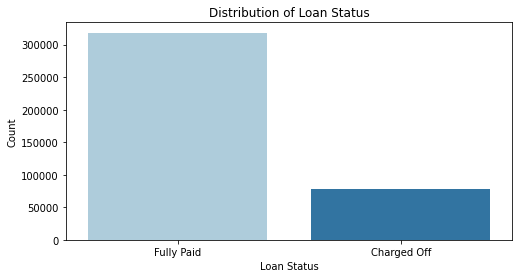

In [ ]:
# Plot the distribution of the target variable
plt.figure(figsize = (8,4))
loan_status_plot = sns.countplot(x='loan_status', data=data, palette='Paired')
loan_status_plot.set_title('Distribution of Loan Status')
loan_status_plot.set_xlabel('Loan Status')
loan_status_plot.set_ylabel('Count')

In [ ]:
# Check the percentage of Fully-paid and Charged-off loans
data['loan_status'].value_counts('Fully Paid')

Fully Paid     0.803871
Charged Off    0.196129
Name: loan_status, dtype: float64

**Comments:**
The number of fully paid loans accounts for more than 80% of the total loans, while that of charged off is approximately 20%.

## 1.3 Multivariate Analysis

### 1.3.1 Loan Characteristics Features

Text(0, 0.5, 'Count')

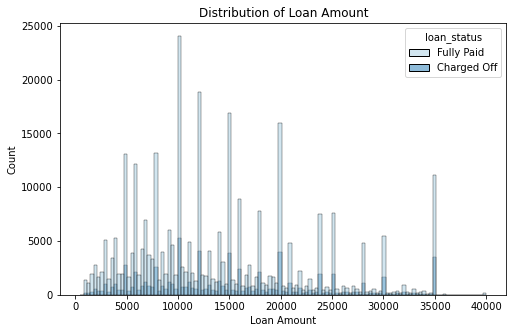

In [3]:
# Loan amount
plt.figure(figsize = (8,5))
loan_amnt_plot = sns.histplot(x='loan_amnt', data=data, hue='loan_status', palette='Paired')
loan_amnt_plot.set_title('Distribution of Loan Amount')
loan_amnt_plot.set_xlabel('Loan Amount')
loan_amnt_plot.set_ylabel('Count')

Text(0, 0.5, 'Count')

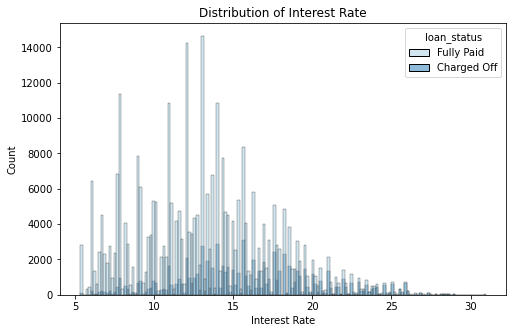

In [4]:
# Interest rate
plt.figure(figsize = (8,5))
int_rate_plot = sns.histplot(x='int_rate', data=data, hue='loan_status', palette='Paired')
int_rate_plot.set_title('Distribution of Interest Rate')
int_rate_plot.set_xlabel('Interest Rate')
int_rate_plot.set_ylabel('Count')

Text(0, 0.5, 'Count')

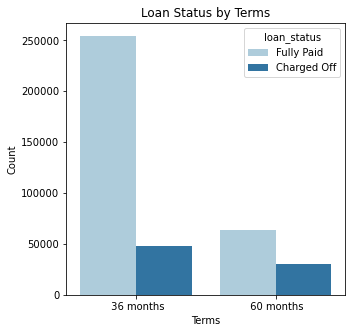

In [5]:
# Term
plt.figure(figsize=(5, 5))
ax = sns.countplot(x='term', data=data, hue="loan_status", palette="Paired")
ax.set_title('Loan Status by Terms')
ax.set_xlabel('Terms')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

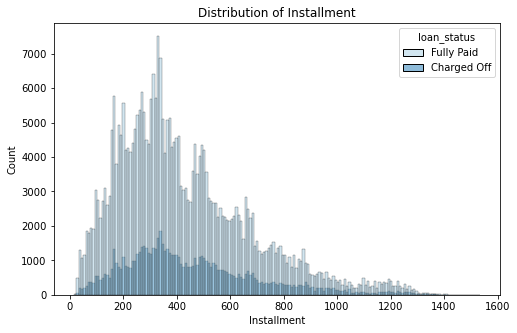

In [6]:
# Installment
plt.figure(figsize = (8,5))
installment_plot = sns.histplot(x='installment', data=data, hue='loan_status', palette='Paired')
installment_plot.set_title('Distribution of Installment')
installment_plot.set_xlabel('Installment')
installment_plot.set_ylabel('Count')

**Comments:**
The distribution of Installment seems to follow the Normal distribution, but has quite heavy right tail.

In [7]:
# Grade & Subgrade
## Unique values for grade and sub_grade
print(f"GRADE unique: {data.grade.unique()}")
print(f"SUB_GRADE unique: {data.sub_grade.unique()}")

GRADE unique: ['B' 'A' 'C' 'E' 'D' 'F' 'G']
SUB_GRADE unique: ['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1' 'F3' 'G5' 'G4' 'F2' 'G3']


Text(0.5, 1.0, 'Type of Loans by Sub-Grade')

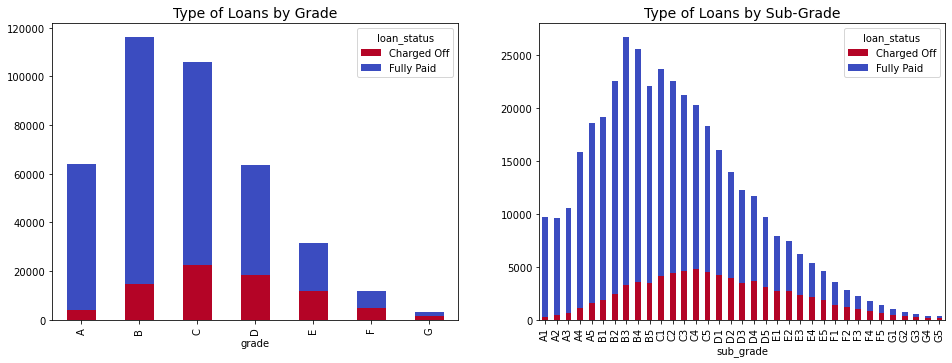

In [8]:
## Plots for fully_paid and charged_off loans by grade & sub-grade
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

cmap = plt.cm.coolwarm_r

loans_by_grade = data.groupby(['grade', 'loan_status']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)

loans_by_sub_grade = data.groupby(['sub_grade', 'loan_status']).size()
loans_by_sub_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

**Comments:** The distribution of Sub-grade seems to follow the Normal distribution, but has quite heavy right tail.

Text(0, 0.5, 'Count')

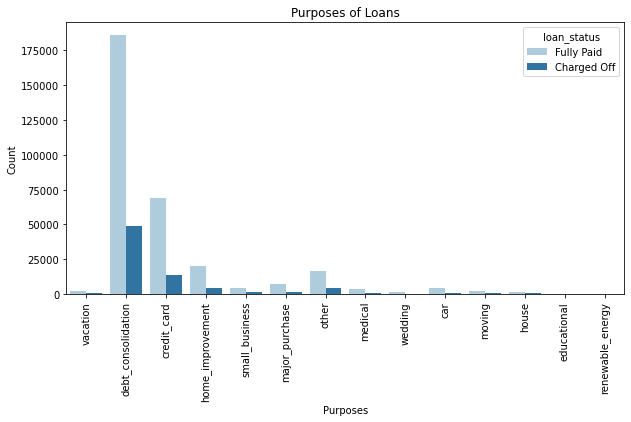

In [9]:
# Purpose & Title
## Purpose: A category provided by the borrower for the loan request
### Plot Loan status by Purpose
plt.figure(figsize=(10, 5))
purpose_plot = sns.countplot(x='purpose', data=data, hue='loan_status', palette="Paired")
purpose_plot.set_xticklabels(purpose_plot.get_xticklabels(), rotation=90)
purpose_plot.set_title('Purposes of Loans')
purpose_plot.set_xlabel('Purposes')
purpose_plot.set_ylabel('Count')

In [10]:
## Title: The loan title provided by the borrower
### Top 10 titles of the loan purpose
data['title'] = data.title.str.lower()
data.title.value_counts()[:10]

debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
Name: title, dtype: int64

Text(0, 0.5, 'Count')

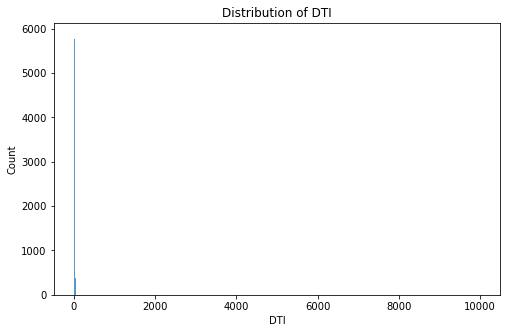

In [11]:
# dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested Lending Club loan, divided by the borrower’s self-reported monthly income (monthly debt/monthly income)
plt.figure(figsize = (8,5))
dti_plot = sns.histplot(x='dti', data=data, palette='Paired')
dti_plot.set_title('Distribution of DTI')
dti_plot.set_xlabel('DTI')
dti_plot.set_ylabel('Count')

**Comments**: There are outliers in this feature. We'll look at the box plot and use the Inter Quartile Range to detect the outliers.

[Text(0.5, 1.0, 'Box Plot of DTI')]

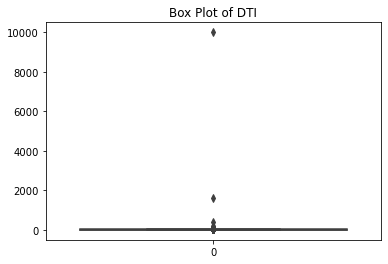

In [12]:
## Box Plot of DTI
sns.boxplot(data=data['dti']).set(title="Box Plot of DTI")

In [13]:
## The outliers lie in the upper range, so we'll use the upper limit to detect the outliers
IQR_dti = data.dti.quantile(0.75) - data.dti.quantile(0.25)
upper_limit_dti = data.dti.quantile(0.75) + (IQR_dti * 1.5)
upper_limit_dti

40.53

Text(0, 0.5, 'Count')

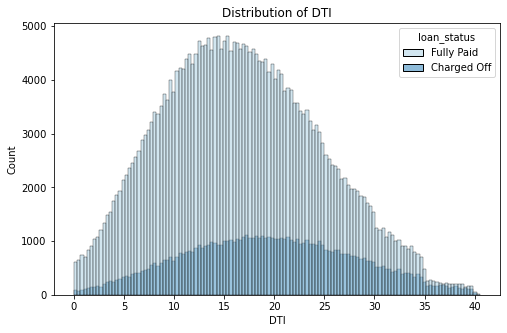

In [14]:
## Sub plot for DTI <= upper_limit
plt.figure(figsize = (8,5))
sub_dti_plot = sns.histplot(x='dti', data=data[data['dti']<=upper_limit_dti], hue='loan_status', palette='Paired')
sub_dti_plot.set_title('Distribution of DTI')
sub_dti_plot.set_xlabel('DTI')
sub_dti_plot.set_ylabel('Count')

Text(0, 0.5, 'Count')

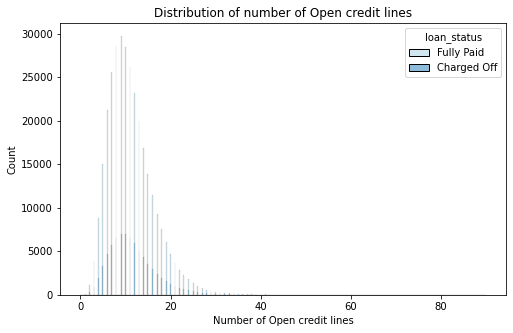

In [15]:
# open_acc: The number of open credit lines in the borrower's credit file
plt.figure(figsize = (8,5))
open_acc_plot = sns.histplot(x='open_acc', data=data, hue='loan_status', palette='Paired')
open_acc_plot.set_title('Distribution of number of Open credit lines')
open_acc_plot.set_xlabel('Number of Open credit lines')
open_acc_plot.set_ylabel('Count')

Text(0, 0.5, 'Count')

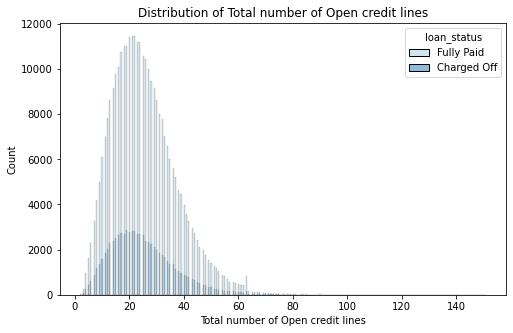

In [16]:
# total_acc: The total number of credit lines currently in the borrower's credit file
plt.figure(figsize = (8,5))
total_acc_plot = sns.histplot(x='total_acc', data=data, hue='loan_status', palette='Paired')
total_acc_plot.set_title('Distribution of Total number of Open credit lines')
total_acc_plot.set_xlabel('Total number of Open credit lines')
total_acc_plot.set_ylabel('Count')

Text(0, 0.5, 'Count')

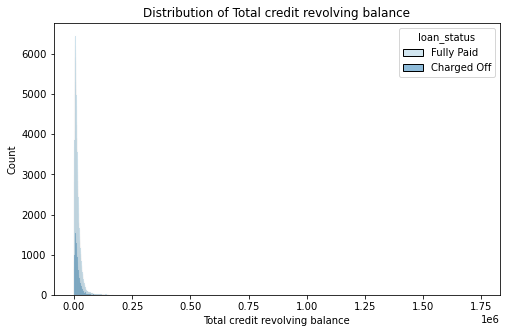

In [17]:
# revol_bal: Total credit revolving balance
plt.figure(figsize = (8,5))
revol_bal_plot = sns.histplot(x='revol_bal', data=data, hue='loan_status', palette='Paired')
revol_bal_plot.set_title('Distribution of Total credit revolving balance')
revol_bal_plot.set_xlabel('Total credit revolving balance')
revol_bal_plot.set_ylabel('Count')

**Comments**: There are outliers in this feature. We'll look at the box plot and use the Inter Quartile Range to detect the outliers.

[Text(0.5, 1.0, 'Box Plot of Total credit revolving balance')]

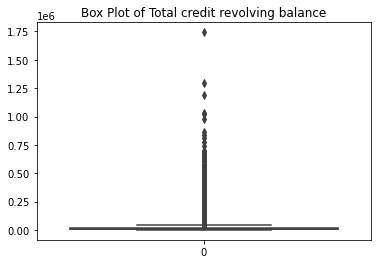

In [18]:
# Box Plot of revol_bal
sns.boxplot(data=data['revol_bal']).set(title="Box Plot of Total credit revolving balance")

In [19]:
## The outliers lie in the upper range, so we'll use the upper limit to detect the outliers
IQR_revol_bal = data.revol_bal.quantile(0.75) - data.revol_bal.quantile(0.25)
upper_limit_revol_bal = data.revol_bal.quantile(0.75) + (IQR_revol_bal * 1.5)
upper_limit_revol_bal

40012.5

Text(0, 0.5, 'Count')

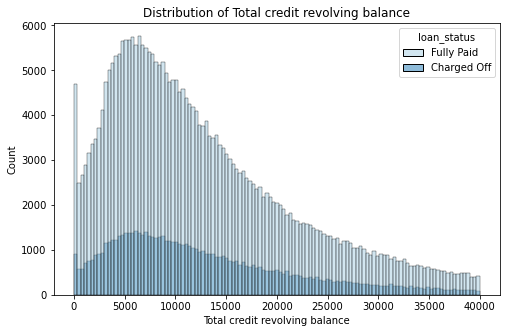

In [20]:
## Sub plot for revol_bal <= upper_limit
plt.figure(figsize = (8,5))
sub_revol_bal_plot = sns.histplot(x='revol_bal', data=data[data['revol_bal']<=upper_limit_revol_bal], hue='loan_status', palette='Paired')
sub_revol_bal_plot.set_title('Distribution of Total credit revolving balance')
sub_revol_bal_plot.set_xlabel('Total credit revolving balance')
sub_revol_bal_plot.set_ylabel('Count')

Text(0, 0.5, 'Count')

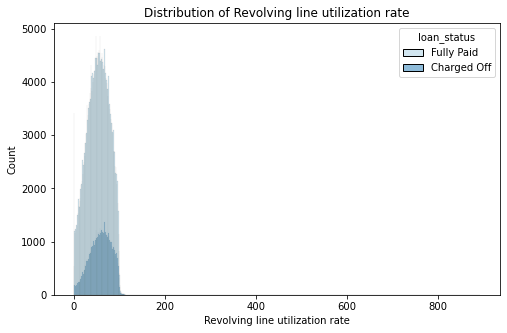

In [21]:
# revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit
plt.figure(figsize = (8,5))
revol_util_plot = sns.histplot(x='revol_util', data=data, hue='loan_status', palette='Paired')
revol_util_plot.set_title('Distribution of Revolving line utilization rate')
revol_util_plot.set_xlabel('Revolving line utilization rate')
revol_util_plot.set_ylabel('Count')

**Comments**: There are outliers in this feature. We'll use the Inter Quartile Range to detect the outliers.

In [22]:
## The outliers lie in the upper range, so we'll use the upper limit to detect the outliers
IQR_revol_util = data.revol_util.quantile(0.75) - data.revol_util.quantile(0.25)
upper_limit_revol_util = data.revol_util.quantile(0.75) + (IQR_revol_util * 1.5)
upper_limit_revol_util

128.55

Text(0, 0.5, 'Count')

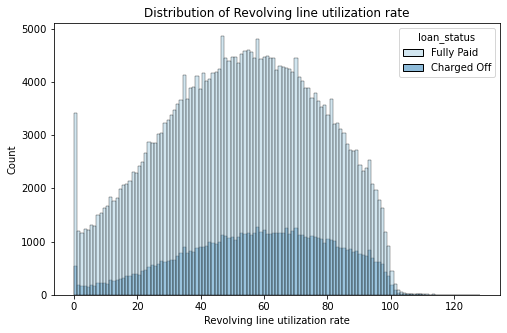

In [23]:
## Sub plot for revol_util <= upper_limit
plt.figure(figsize = (8,5))
sub_revol_util_plot = sns.histplot(x='revol_util', data=data[data['revol_util']<=upper_limit_revol_util], hue='loan_status', palette='Paired')
sub_revol_util_plot.set_title('Distribution of Revolving line utilization rate')
sub_revol_util_plot.set_xlabel('Revolving line utilization rate')
sub_revol_util_plot.set_ylabel('Count')

In [24]:
# pub_rec, initial_list_status, application_type, mort_acc, & pub_rec_bankruptcies

## pub_rec: Number of derogatory public records
## initial_list_status: The initial listing status of the loan. Possible values are – W, F
## application_type: Indicates whether the loan is an individual application or a joint application with two co-borrowers
## mort_acc: Number of mortgage accounts
## pub_rec_bankruptcies: Number of public record bankruptcies

In [25]:
## Features cleaning
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['mort_acc'] = data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<AxesSubplot:xlabel='pub_rec_bankruptcies', ylabel='count'>

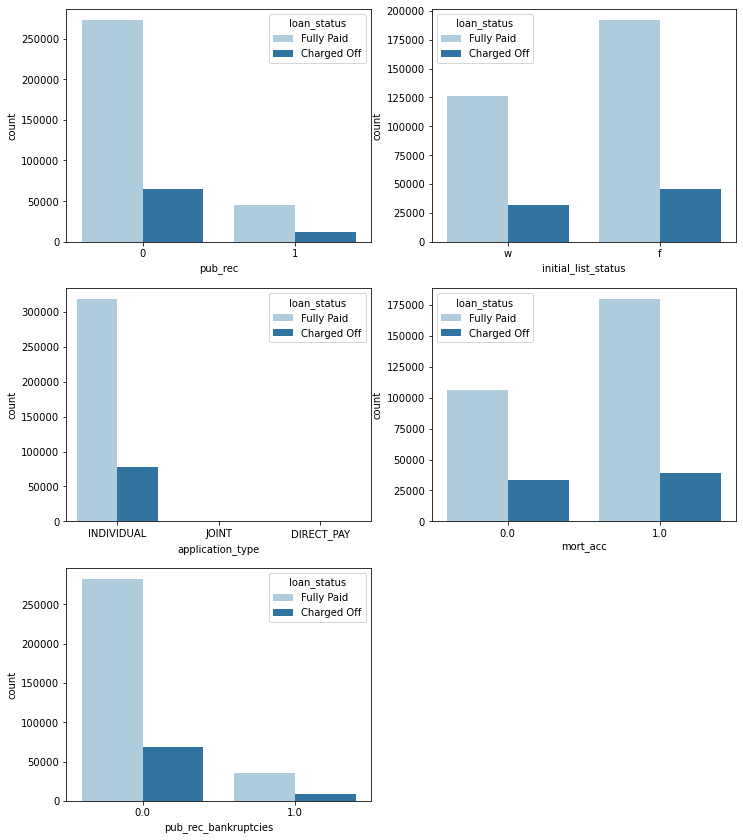

In [26]:
plt.figure(figsize=(12, 30))

plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=data, hue='loan_status', palette='Paired')

plt.subplot(6, 2, 2)
sns.countplot(x='initial_list_status', data=data, hue='loan_status', palette='Paired')

plt.subplot(6, 2, 3)
sns.countplot(x='application_type', data=data, hue='loan_status', palette='Paired')

plt.subplot(6, 2, 4)
sns.countplot(x='mort_acc', data=data, hue='loan_status', palette='Paired')

plt.subplot(6, 2, 5)
sns.countplot(x='pub_rec_bankruptcies', data=data, hue='loan_status', palette='Paired')

### 1.3.2 Applicants' Demographics Features

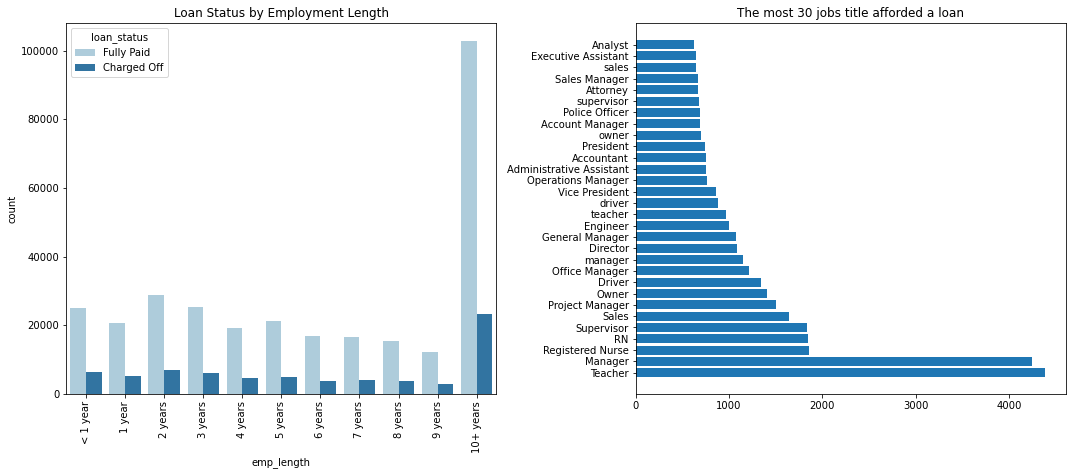

In [27]:
# Employment title & Employment length

## emp_title: The job title supplied by the Borrower when applying for the loan
## emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
emp_length_plot = sns.countplot(x='emp_length', data=data, hue='loan_status', order=order, palette='Paired')
emp_length_plot.set_xticklabels(emp_length_plot.get_xticklabels(), rotation=90)
emp_length_plot.set(title='Loan Status by Employment Length');

plt.subplot(2, 2, 2)
plt.barh(data.emp_title.value_counts()[:30].index, data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a loan")
plt.tight_layout()

In [28]:
# Home ownership: The home ownership status provided by the borrower during registration or obtained from the credit report
data['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [29]:
## Group 'other', 'none' and 'any' to 'other' only
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
data.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: home_ownership, dtype: int64

[Text(0.5, 1.0, 'Loan Status by Home Ownership Status')]

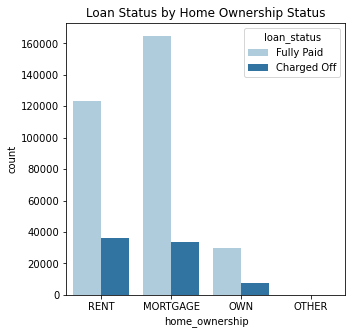

In [30]:
## Plot the Loan Status by Home Ownership Status
plt.figure(figsize=(5, 5))
home_ownership_plot = sns.countplot(x='home_ownership', data=data, hue='loan_status', palette='Paired')
home_ownership_plot.set(title='Loan Status by Home Ownership Status')

In [31]:
# Annual income: Low, Medium and High?

## Create categories for annual_income since most of the bad loans are located below 100k
## Source: https://www.kaggle.com/code/janiobachmann/lending-club-risk-analysis-and-metrics/notebook

data['income_category'] = np.nan
lst = [data]

for col in lst:
    col.loc[col['annual_inc'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_inc'] > 100000) & (col['annual_inc'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_inc'] > 200000, 'income_category'] = 'High'

<AxesSubplot:xlabel='income_category', ylabel='loan_status'>

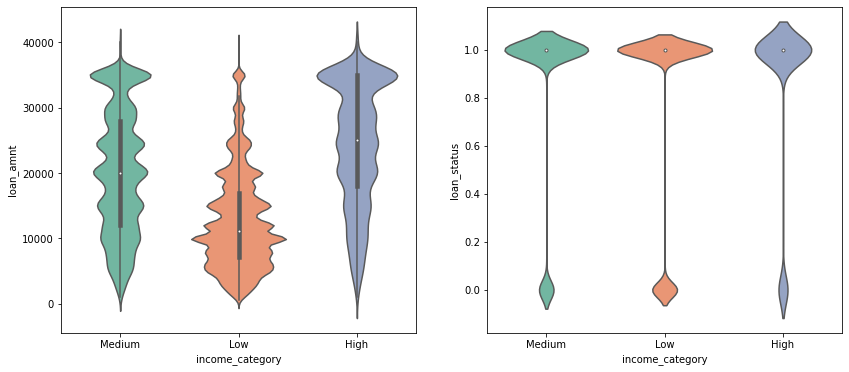

In [32]:
## Transform our target variable from categorical to numerical variable to do the Violin Plot
data['loan_status'] = data.loan_status.map({'Fully Paid':1, 'Charged Off':0})

fig, ((ax1, ax2))= plt.subplots(nrows=1, ncols=2, figsize=(14,6))

sns.violinplot(x="income_category", y="loan_amnt", data=data, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_status", data=data, palette="Set2", ax=ax2)

**Comments:**
- Borrowers that made part of the high income category took higher loan amounts than people from low and medium income categories. Of course, people with higher annual incomes are more likely to pay loans with a higher amount.
- Loans that were borrowed by the Low income category had a slightly higher change of becoming a charge-off loan.

[Text(0.5, 1.0, 'Loan Status by Verification Status')]

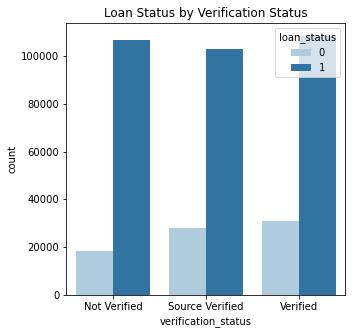

In [33]:
# Verification_status: Indicates if income was verified by Lending Club, not verified, or if the income source was verified

plt.figure(figsize=(5, 5))
verification_status_plot = sns.countplot(x='verification_status', data=data, hue='loan_status', palette='Paired')
verification_status_plot.set(title='Loan Status by Verification Status')

# 2. Data Preprocessing

- Detect and Treat Duplicates & Missing values
- Feature Engineering (e.g., Transform the categorical variables into dummy variables)
- Split the dataset into Train/ Test/ Validation sets
- Detect and Treat Outliers on the training set only to avoid leaking information from the test set
- Standardize the data (fit on the training set and transform on the test set)
- Deal with imbalanced dataset using SMOTE-NC because most of our variables are categorical, on the training set

## 2.1 Duplicates & Missing values

In [34]:
# Detect duplicate observations
duplicateRows = data[data.duplicated()]
duplicateRows

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,income_category


In [35]:
# Detect missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1755' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [36]:
# emp_title
data.emp_title.nunique()

173105

In [37]:
## Realistically there are too many unique job titles to try to convert this to a dummy variable feature. Hence, we decided to remove the emp_title column
data.drop('emp_title', axis=1, inplace=True)

In [38]:
# emp_length
data.emp_length.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [39]:
for year in data.emp_length.unique():
    print(f"{year} in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

10+ years in this position:
1    0.815814
0    0.184186
Name: loan_status, dtype: float64
4 years in this position:
1    0.807615
0    0.192385
Name: loan_status, dtype: float64
< 1 year in this position:
1    0.793128
0    0.206872
Name: loan_status, dtype: float64
6 years in this position:
1    0.810806
0    0.189194
Name: loan_status, dtype: float64
9 years in this position:
1    0.79953
0    0.20047
Name: loan_status, dtype: float64
2 years in this position:
1    0.806738
0    0.193262
Name: loan_status, dtype: float64
3 years in this position:
1    0.804769
0    0.195231
Name: loan_status, dtype: float64
8 years in this position:
1    0.80024
0    0.19976
Name: loan_status, dtype: float64
7 years in this position:
1    0.805226
0    0.194774
Name: loan_status, dtype: float64
5 years in this position:
1    0.807813
0    0.192187
Name: loan_status, dtype: float64
1 year in this position:
1    0.800865
0    0.199135
Name: loan_status, dtype: float64
nan in this position:
Series([], N

In [40]:
## Charge off rates are extremely similar across all employment lengths. Hence, we decided to drop the emp_length column
data.drop('emp_length', axis=1, inplace=True)

In [41]:
# title
print(data.title.value_counts().head())
print(data.purpose.value_counts().head())

debt consolidation         168108
credit card refinancing     51781
home improvement            17117
other                       12993
consolidation                5583
Name: title, dtype: int64
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
Name: purpose, dtype: int64


In [42]:
## The 'title' column is simply a string subcategory/ description of the purpose column. Hence, we decided to drop the 'title' column
data.drop('title', axis=1, inplace=True)

<AxesSubplot:>

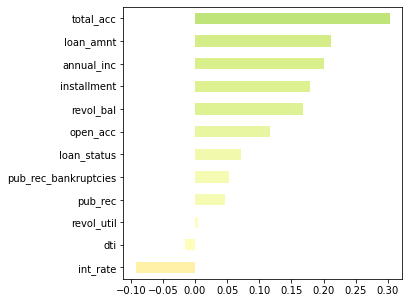

In [43]:
# mort_acc
## There are many ways to deal with these missing values, since we suspect that financial variables tend to relate to each other, we decided to see how 'mort_acc' relate to other variables and use the fillna() method based on this correlation
corrplot = data.corr()['mort_acc'].drop('mort_acc').sort_values()

## Source: https://python.plainenglish.io/why-using-bar-charts-instead-of-matrix-is-helpful-to-visualize-correlation-b68fdc143c1f
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(figsize =(5,5))

norm = TwoSlopeNorm(vmin=-1, vcenter =0, vmax=1)
colors = [plt.cm.RdYlGn(norm(c)) for c in corrplot.values]

corrplot.plot.barh(color=colors)

In [44]:
## As can be seen from the graph, mort_acc correlates the most with total_acc. This makes sense since the total number of credit lines currently in the borrower's credit file can provide some information about the number of mortgage accounts in the reality, to some extent. Hence, we will group the dataframe by the total_acc and calculate the mean value for the mort_acc per total_acc entry.
total_acc_avg = data.groupby(by='total_acc').mean().mort_acc

In [45]:
def fill_mort_acc(total_acc, mort_acc):
  if np.isnan(mort_acc):
    return total_acc_avg[total_acc].round()
  else:
    return mort_acc

In [46]:
data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [47]:
# revol_util & pub_rec_bankruptcies
for column in data.columns:

    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'revol_util': number of missing values '276' ==> '0.070%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [48]:
### These two features have missing data points, but they account for less than 0.5% of the total data. Hence, we decided to remove the rows that are missing those values in those columns with dropna()
data.dropna(inplace=True)

## 2.2 Feature Engineering

### Simple cleaning

In [49]:
print([column for column in data.columns if data[column].dtype == object])

['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address', 'income_category']


In [50]:
# term
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [51]:
# sub_grade
data.sub_grade.unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

In [52]:
# Transform sub-grade column to numerical values
sub_grade_values = {'A1': 1, 'A2': 1.2, 'A3': 1.4, 'A4': 1.6, 'A5': 1.8,
                    'B1': 2, 'B2': 2.2, 'B3': 2.4, 'B4': 2.6, 'B5': 2.8,
                    'C1': 3, 'C2': 3.2, 'C3': 3.4, 'C4': 3.6, 'C5': 3.8,
                    'D1': 4, 'D2': 4.2, 'D3': 4.4, 'D4': 4.6, 'D5': 4.8,
                    'E1': 5, 'E2': 5.2, 'E3': 5.4, 'E4': 5.6, 'E5': 5.8,
                    'F1': 6, 'F2': 6.2, 'F3': 6.4, 'F4': 6.6, 'F5': 6.8,
                    'G1': 7, 'G2': 7.2, 'G3': 7.4, 'G4': 7.6, 'G5': 7.8}
data['sub_grade'] = data.sub_grade.map(sub_grade_values)

In [53]:
# Since grade is just a sub-feature of subgrade, we decided to drop the column 'grade'
data.drop('grade', axis=1, inplace=True)

In [54]:
# adress
data.address.head()

0       0174 Michelle Gateway\r\nMendozaberg, OK 22690
1    1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113
2    87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113
3              823 Reid Ford\r\nDelacruzside, MA 00813
4               679 Luna Roads\r\nGreggshire, VA 11650
Name: address, dtype: object

In [55]:
## We'll feature engineer a zip code column from the address in the data set. Create a column called 'zip_code' that extracts the zip code from the address column
data['zip_code'] = data.address.apply(lambda x: x[-5:])
data.drop('address', axis=1, inplace=True)

In [56]:
# issue_d
## This is data leakage as we should not know beforehand whether or not a loan would be issued when using our model, so we decided to drop this feature
data.drop('issue_d', axis=1, inplace=True)

In [57]:
# earliest_cr_line
## This appears to be a historical time stamp feature, we won't need it for our current classification
data.drop('earliest_cr_line', axis=1, inplace=True)

In [58]:
# Drop the unnecessary column we just created above for visualization purpose
data.drop('income_category', axis=1, inplace=True)

### Transform categorical variables

In [59]:
# Create list with categorical features' names
nonum_feats_names = [column for column in data.columns if data[column].dtype == object]

# Create list with numerical features' names
num_cols_names = [column for column in data.columns if data[column].dtype != object]

print(nonum_feats_names)
print(num_cols_names)

['term', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'zip_code']
['loan_amnt', 'int_rate', 'installment', 'sub_grade', 'annual_inc', 'loan_status', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']


In [60]:
# Assign appropriate data type to categorical variables
nonum_feats = data[nonum_feats_names].astype('category')
nonum_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395219 entries, 0 to 396029
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   term                 395219 non-null  category
 1   home_ownership       395219 non-null  category
 2   verification_status  395219 non-null  category
 3   purpose              395219 non-null  category
 4   initial_list_status  395219 non-null  category
 5   application_type     395219 non-null  category
 6   zip_code             395219 non-null  category
dtypes: category(7)
memory usage: 5.7 MB


In [61]:
# One-hot-code categorical variables and dropping the reference value
ohc_feats = pd.get_dummies(nonum_feats, drop_first=True)
ohc_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395219 entries, 0 to 396029
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   term_ 60 months                      395219 non-null  uint8
 1   home_ownership_OTHER                 395219 non-null  uint8
 2   home_ownership_OWN                   395219 non-null  uint8
 3   home_ownership_RENT                  395219 non-null  uint8
 4   verification_status_Source Verified  395219 non-null  uint8
 5   verification_status_Verified         395219 non-null  uint8
 6   purpose_credit_card                  395219 non-null  uint8
 7   purpose_debt_consolidation           395219 non-null  uint8
 8   purpose_educational                  395219 non-null  uint8
 9   purpose_home_improvement             395219 non-null  uint8
 10  purpose_house                        395219 non-null  uint8
 11  purpose_major_purchase               39

In [62]:
# Create a final dataframe with all numerical variables in the first columns
ohc_data = pd.concat([data[num_cols_names], ohc_feats], axis=1)

### Train/ Test/ Validation split

In [96]:
train, test = train_test_split(ohc_data, test_size=0.2, random_state=rng)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (316175, 45)
Test shape: (79044, 45)


In [97]:
training, validation = train_test_split(train, test_size=0.2, random_state=rng)

print("Training shape:", training.shape)
print("Validation shape:", validation.shape)

Training shape: (252940, 45)
Validation shape: (63235, 45)


In [98]:
# Save validation and test sets as CSV files to save time later on
validation.to_csv('./Data/Validation.csv')
test.to_csv('./Data/Test.csv')

### Outliers Detection & Treatment

#### Firstly, we'll look at the box plots to visually detect the outliers

In [ ]:
# Function to create diagnostic plots
def plotvariable(df, variable):
    plt.figure(figsize=(16,4))
    #histogram
    plt.subplot(1,2,1)
    plt.hist(df[variable], alpha=0.5)
    
    #boxplot
    plt.subplot(1,2,2)
    sns.boxplot(df[variable])
    plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


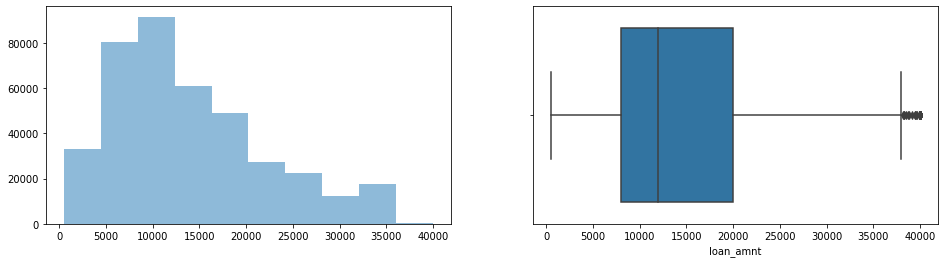

In [ ]:
plotvariable(data, 'loan_amnt')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


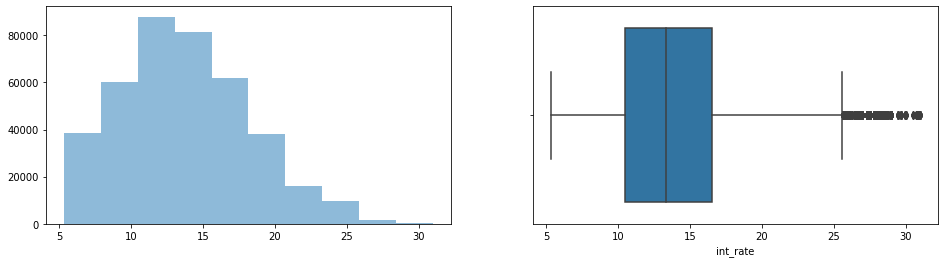

In [ ]:
plotvariable(data, 'int_rate')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


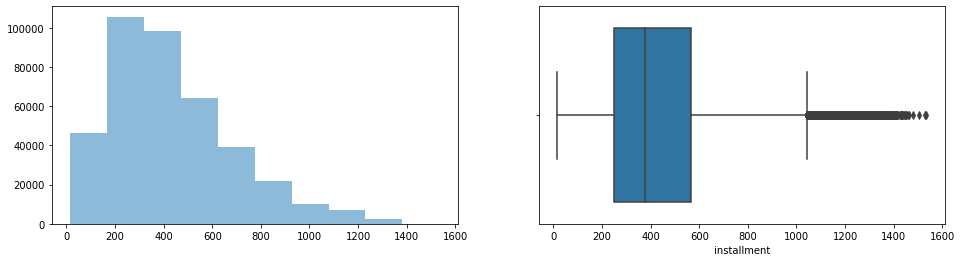

In [ ]:
plotvariable(data, 'installment')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


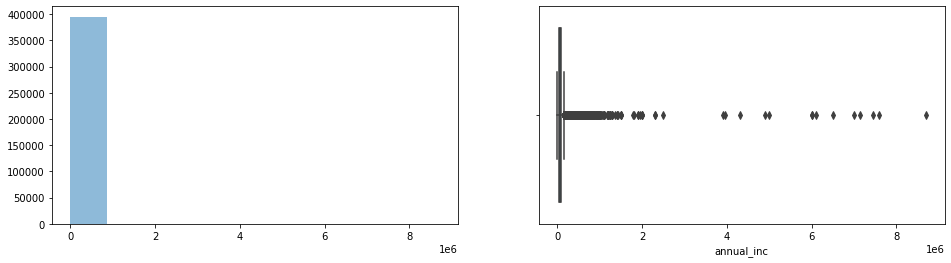

In [ ]:
plotvariable(data, 'annual_inc')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


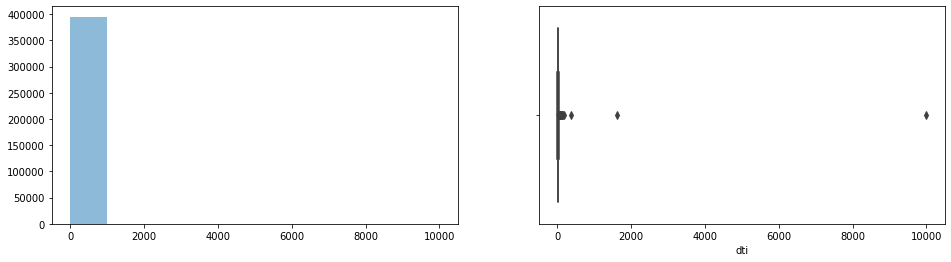

In [ ]:
plotvariable(data, 'dti')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


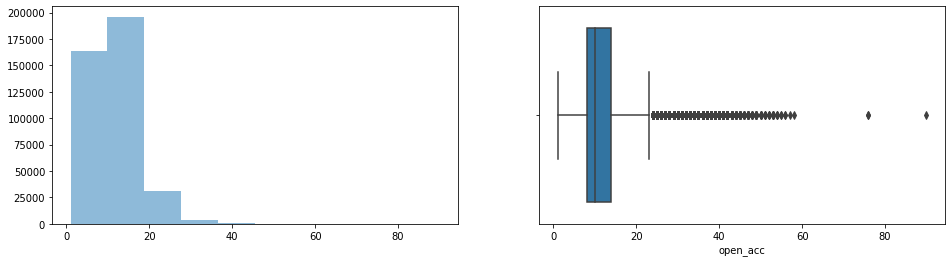

In [ ]:
plotvariable(data, 'open_acc')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


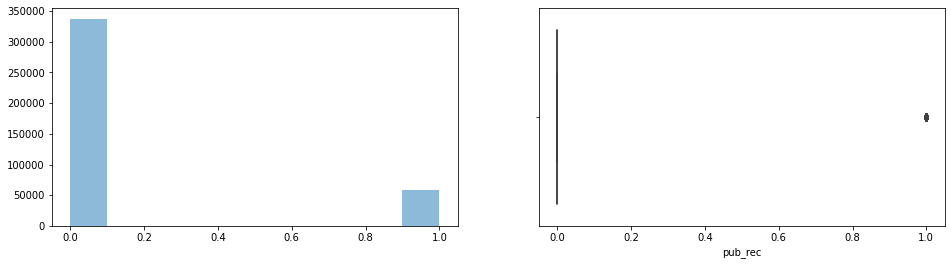

In [ ]:
plotvariable(data, 'pub_rec')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


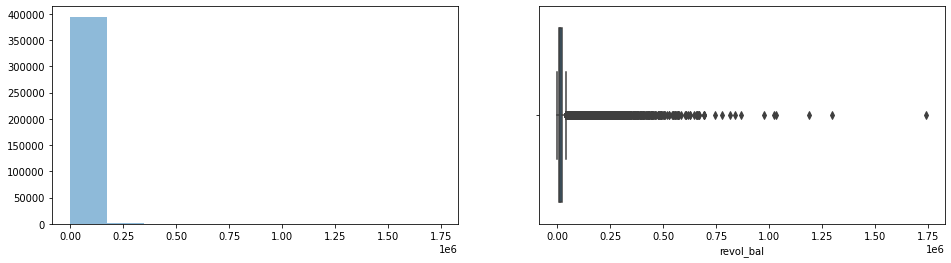

In [ ]:
plotvariable(data, 'revol_bal')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


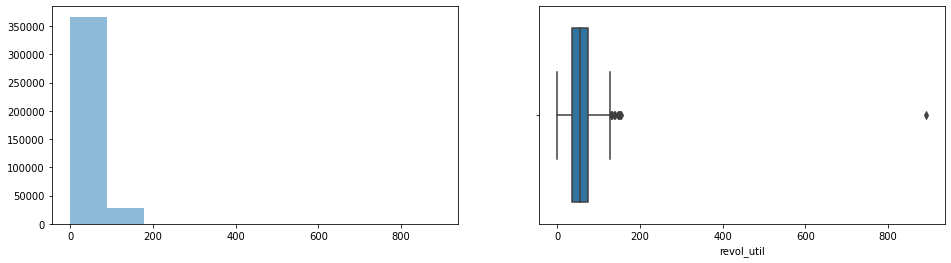

In [ ]:
plotvariable(data, 'revol_util')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


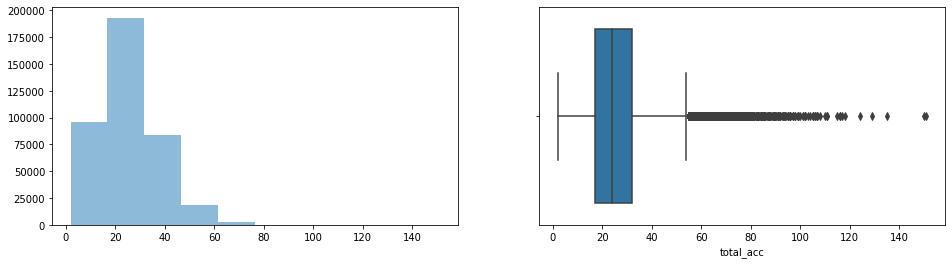

In [ ]:
plotvariable(data, 'total_acc')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


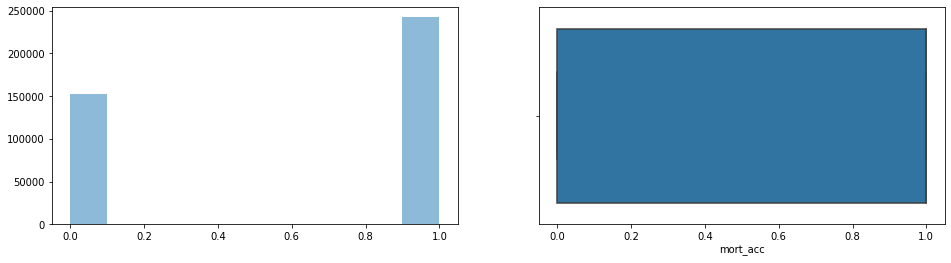

In [ ]:
plotvariable(data, 'mort_acc')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


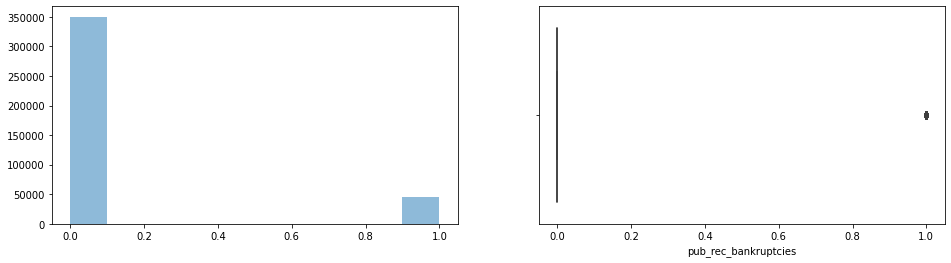

In [ ]:
plotvariable(data, 'pub_rec_bankruptcies')

#### Now, we'll use Inter Quartile Range to closely detect the outliers

In [49]:
# Create a function to calculate the Inter Quartile Range
def find_boundaries(df, variables):
    Q1 = df[variables].quantile(.25)
    Q3 = df[variables].quantile(.75)
    IQR = Q3 - Q1
    lower_boundary = Q1 - 3*IQR
    upper_boundary = Q3 + 3*IQR
    return lower_boundary, upper_boundary

In [99]:
# loan_amnt
lower_loan_amnt, upper_loan_amnt = find_boundaries(training, 'loan_amnt')
print('The upper limit for loan_amnt is', upper_loan_amnt)
print('The lower limit for loan_amnt is', lower_loan_amnt)

outliers_loan_amnt = np.where(training['loan_amnt']>upper_loan_amnt, True,
                             np.where(training['loan_amnt']<lower_loan_amnt, True, False))

training = training.loc[~(outliers_loan_amnt),]

training.shape

The upper limit for loan_amnt is 56000.0
The lower limit for loan_amnt is -28000.0


(252940, 45)

In [100]:
# int_rate
lower_int_rate, upper_int_rate = find_boundaries(training, 'int_rate')
print('The upper limit for int_rate is', upper_int_rate)
print('The lower limit for int_rate is', lower_int_rate)

outliers_int_rate = np.where(training['int_rate']>upper_int_rate, True,
                             np.where(training['int_rate']<lower_int_rate, True, False))

training = training.loc[~(outliers_int_rate),]

training.shape

The upper limit for int_rate is 34.489999999999995
The lower limit for int_rate is -7.509999999999993


(252940, 45)

In [101]:
# installment
lower_installment, upper_installment = find_boundaries(training, 'installment')
print('The upper limit for installment is', upper_installment)
print('The lower limit for installment is', lower_installment)

outliers_installment = np.where(training['installment']>upper_installment, True,
                             np.where(training['installment']<lower_installment, True, False))

training = training.loc[~(outliers_installment),]

training.shape

The upper limit for installment is 1521.6675
The lower limit for installment is -702.6699999999998


(252939, 45)

In [102]:
# annual_inc
lower_annual_inc, upper_annual_inc = find_boundaries(training, 'annual_inc')
print('The upper limit for annual_inc is', upper_annual_inc)
print('The lower limit for annual_inc is', lower_annual_inc)

outliers_annual_inc = np.where(training['annual_inc']>upper_annual_inc, True,
                             np.where(training['annual_inc']<lower_annual_inc, True, False))

training = training.loc[~(outliers_annual_inc),]

training.shape

The upper limit for annual_inc is 225000.0
The lower limit for annual_inc is -90000.0


(249773, 45)

In [103]:
# dti 
lower_dti, upper_dti = find_boundaries(training, 'dti')
print('The upper limit for dti is', upper_dti)
print('The lower limit for dti is', lower_dti)

outliers_dti = np.where(training['dti']>upper_dti, True,
                             np.where(training['dti']<lower_dti, True, False))

training = training.loc[~(outliers_dti),]

training.shape

The upper limit for dti is 58.050000000000004
The lower limit for dti is -23.570000000000004


(249757, 45)

In [104]:
# open_acc
lower_open_acc, upper_open_acc = find_boundaries(training, 'open_acc')
print('The upper limit for open_acc is', upper_open_acc)
print('The lower limit for open_acc is', lower_open_acc)

outliers_open_acc = np.where(training['open_acc']>upper_open_acc, True,
                             np.where(training['open_acc']<lower_open_acc, True, False))

training = training.loc[~(outliers_open_acc),]

training.shape

The upper limit for open_acc is 32.0
The lower limit for open_acc is -10.0


(249006, 45)

In [105]:
# revol_bal
lower_revol_bal, upper_revol_bal = find_boundaries(training, 'revol_bal')
print('The upper limit for revol_bal is', upper_revol_bal)
print('The lower limit for revol_bal is', lower_revol_bal)

outliers_revol_bal = np.where(training['revol_bal']>upper_revol_bal, True,
                             np.where(training['revol_bal']<lower_revol_bal, True, False))

training = training.loc[~(outliers_revol_bal),]

training.shape

The upper limit for revol_bal is 59457.0
The lower limit for revol_bal is -34089.25


(244531, 45)

In [106]:
# revol_util
lower_revol_util, upper_revol_util = find_boundaries(training, 'revol_util')
print('The upper limit for revol_util is', upper_revol_util)
print('The lower limit for revol_util is', lower_revol_util)

outliers_revol_util = np.where(training['revol_util']>upper_revol_util, True,
                             np.where(training['revol_util']<lower_revol_util, True, False))

training = training.loc[~(outliers_revol_util),]

training.shape

The upper limit for revol_util is 183.29999999999995
The lower limit for revol_util is -74.99999999999997


(244530, 45)

In [107]:
# total_acc
lower_total_acc, upper_total_acc = find_boundaries(training, 'total_acc')
print('The upper limit for total_acc is', upper_total_acc)
print('The lower limit for total_acc is', lower_total_acc)

outliers_total_acc = np.where(training['total_acc']>upper_total_acc, True,
                             np.where(training['total_acc']<lower_total_acc, True, False))

training = training.loc[~(outliers_total_acc),]

training.shape

The upper limit for total_acc is 77.0
The lower limit for total_acc is -28.0


(244385, 45)

In [108]:
# Save training set as CSV file
training.to_csv('./Data/Training.csv')

### Load the training, validation and test sets again

In [63]:
validation = pd.read_csv('./Data/Validation.csv')
# Drop the old index column
validation.drop('Unnamed: 0', axis=1, inplace=True)

test = pd.read_csv('./Data/Test.csv')
# Drop the old index column
test.drop('Unnamed: 0', axis=1, inplace=True)

training = pd.read_csv('./Data/Training.csv')
# Drop the old index column
training.drop('Unnamed: 0', axis=1, inplace=True)

In [64]:
training.head()

,loan_amnt,int_rate,installment,sub_grade,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,...,application_type_JOINT,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
0,14000.0,14.27,480.33,3.2,35000.0,1,8.40,12.0,0,13018.0,...,0,1,0,0,0,0,0,0,0,0
1,23000.0,17.27,574.96,3.8,53000.0,1,10.30,12.0,0,18262.0,...,0,0,0,0,0,0,1,0,0,0
2,15000.0,19.52,393.42,5.2,54000.0,1,17.73,9.0,0,9375.0,...,0,0,0,0,0,0,0,1,0,0
3,33000.0,12.12,1097.97,2.4,130000.0,1,12.78,5.0,0,8019.0,...,0,0,0,0,0,1,0,0,0,0
4,4800.0,14.30,164.76,3.0,65000.0,0,18.71,6.0,0,9014.0,...,0,0,0,0,0,1,0,0,0,0


### Data Standardization

In [65]:
X_training = training.drop(columns=['loan_status'], axis=1)
y_training = training['loan_status']

X_validation = validation.drop(columns=['loan_status'], axis=1)
y_validation = validation['loan_status']

X_test = test.drop(columns=['loan_status'], axis=1)
y_test = test['loan_status']

In [66]:
# Copy the result of num_cols_names above, remove the target variable 'loan_status' for standardization purpose
num_cols_names = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

In [67]:
scaler = StandardScaler()

# Fit transform the numerical features in the training set to a new dataframe
scaled_numfeats_train = pd.DataFrame(scaler.fit_transform(X_training[num_cols_names]), 
                                     columns=num_cols_names, index= X_training.index)
# Integrate scaled values to the training set
for col in num_cols_names:
    X_training[col] = scaled_numfeats_train[col]


# Transform the numerical features in the test set to a new dataframe
scaled_numfeats_test = pd.DataFrame(scaler.transform(X_test[num_cols_names]),
                                    columns=num_cols_names, index= X_test.index)
# Integrate scaled values to the test set
for col in num_cols_names:
    X_test[col] = scaled_numfeats_test[col]


# Transform the numerical features in the validation set to a new dataframe
scaled_numfeats_validation = pd.DataFrame(scaler.transform(X_validation[num_cols_names]),
                                    columns=num_cols_names, index= X_validation.index)
# Integrate scaled values to the validation set
for col in num_cols_names:
    X_validation[col] = scaled_numfeats_validation[col]

### Imbalanced Dataset Treatment with SMOTE-NC

#### Tranform the dataset

In [120]:
# Create a list of indices for categorical variables
cat_col_index = list(range(len(num_cols_names), 43)) # Because the dummy variables are in the last columns while we have a total of 44 features

In [121]:
sm = SMOTENC(categorical_features=cat_col_index, random_state=rng)

X_sm, y_sm = sm.fit_resample(X_training, y_training) 

print(f'''Shape of X before SMOTE: {X_training.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True)*100

Shape of X before SMOTE: (244385, 44)
Shape of X after SMOTE: (392040, 44)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: loan_status, dtype: float64

In [122]:
# Transform X_sm and y_sm to DataFrames
X_sm_df = pd.DataFrame(X_sm, columns=X_training.columns)
y_sm_df = pd.DataFrame(y_sm)

In [123]:
# Concatenate X_sm_df and y_sm_df to run Autometrics on OxMetrics
sm_df = pd.concat([X_sm_df, y_sm_df], axis=1) # aixs=1 concatenate along columns to make horizontal database, =0 otherwise
sm_df.head()

,loan_amnt,int_rate,installment,sub_grade,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,...,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,loan_status
0,0.018534,0.137062,0.231107,3.2,-1.001508,-1.108392,0.171575,-0.417433,-0.069257,0.495066,...,1,0,0,0,0,0,0,0,0,1
1,1.121684,0.809669,0.619202,3.8,-0.480941,-0.873830,0.171575,-0.417433,0.418945,1.086526,...,0,0,0,0,0,1,0,0,0,1
2,0.141106,1.314123,-0.125327,5.2,-0.452021,0.043434,-0.443308,-0.417433,-0.408410,-0.153897,...,0,0,0,0,0,0,1,0,0,1
3,2.347405,-0.344972,2.764162,2.4,1.745929,-0.567664,-1.263151,-0.417433,-0.534649,-0.207292,...,0,0,0,0,1,0,0,0,0,1
4,-1.109130,0.143789,-1.063104,3.0,-0.133896,0.164419,-1.058190,-0.417433,-0.442018,0.987950,...,0,0,0,0,1,0,0,0,0,0


In [124]:
# Save X and y after SMOTE as CSV files to save time later on

X_sm_df.to_csv('./Data/X_sm.csv')
y_sm_df.to_csv('./Data/y_sm.csv')
sm_df.to_csv('./Data/sm_df.csv')

#### Load the SMOTE dataset again

In [68]:
X_sm = pd.read_csv('./Data/X_sm.csv')
# Drop the old index column
X_sm.drop('Unnamed: 0', axis=1, inplace=True)

y_sm = pd.read_csv('./Data/y_sm.csv')
# Drop the old index column
y_sm.drop('Unnamed: 0', axis=1, inplace=True)


## 2.2 Correlational analysis



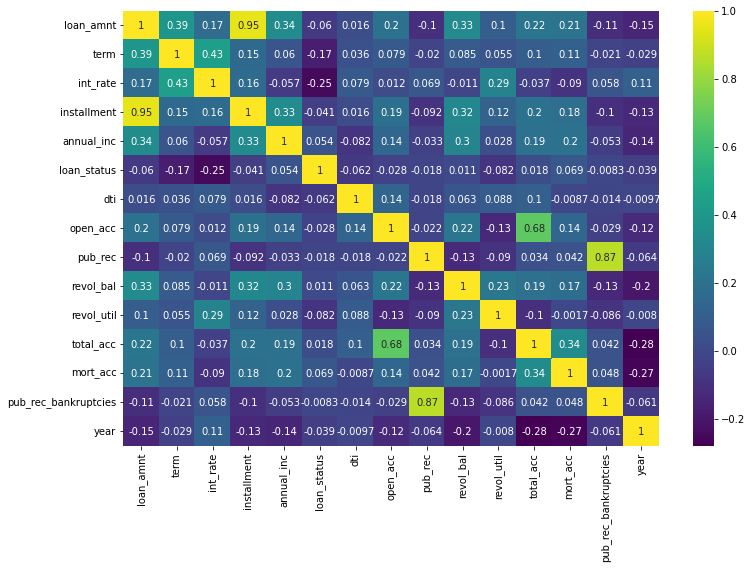

In [ ]:
# Correlational matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data[num_cols_names].corr(), annot=True, cmap='viridis')

**Comments :**

There is high correlation between : 
*  Installment and loan_amount with 95%  
*  Pub_rec and pub_rec_bankruptcies with 87%
*  Total_acc and open_acc with 68%


The heat map does not talk about the relationship between more than two variables. Hence, we compute the **Variance Inflation Factor** to better detect the multicollinearity problem.

In [ ]:
# Select the numerical data
num_feats = data[num_cols_names]
num_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395219 entries, 0 to 396029
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             395219 non-null  float64
 1   term                  395219 non-null  int64  
 2   int_rate              395219 non-null  float64
 3   installment           395219 non-null  float64
 4   annual_inc            395219 non-null  float64
 5   loan_status           395219 non-null  int64  
 6   dti                   395219 non-null  float64
 7   open_acc              395219 non-null  float64
 8   pub_rec               395219 non-null  int64  
 9   revol_bal             395219 non-null  float64
 10  revol_util            395219 non-null  float64
 11  total_acc             395219 non-null  float64
 12  mort_acc              395219 non-null  float64
 13  pub_rec_bankruptcies  395219 non-null  float64
 14  year                  395219 non-null  int64  
dtype

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF_df = pd.DataFrame()
VIF_df['Feature name'] = num_feats.columns
VIF_df['Variance Inflation Factor'] = [variance_inflation_factor(num_feats.values, i) for i in range(len(num_feats.columns))]
VIF_df

,Feature name,Variance Inflation Factor
0,loan_amnt,226.958690
1,term,116.444380
2,int_rate,22.867651
3,installment,203.377241
4,annual_inc,3.033681
5,loan_status,5.514942
6,dti,2.025930
7,open_acc,11.760811
8,pub_rec,4.778457
9,revol_bal,2.095968


**Comments:**

 We noticed that the VIF is very high for loan_amnt, term, installment and year; fairly high for int_rate, open_acc and total_acc, which means that these variables are highly correlated. Hence, considering these features together leads to a model with high multicollinearity.

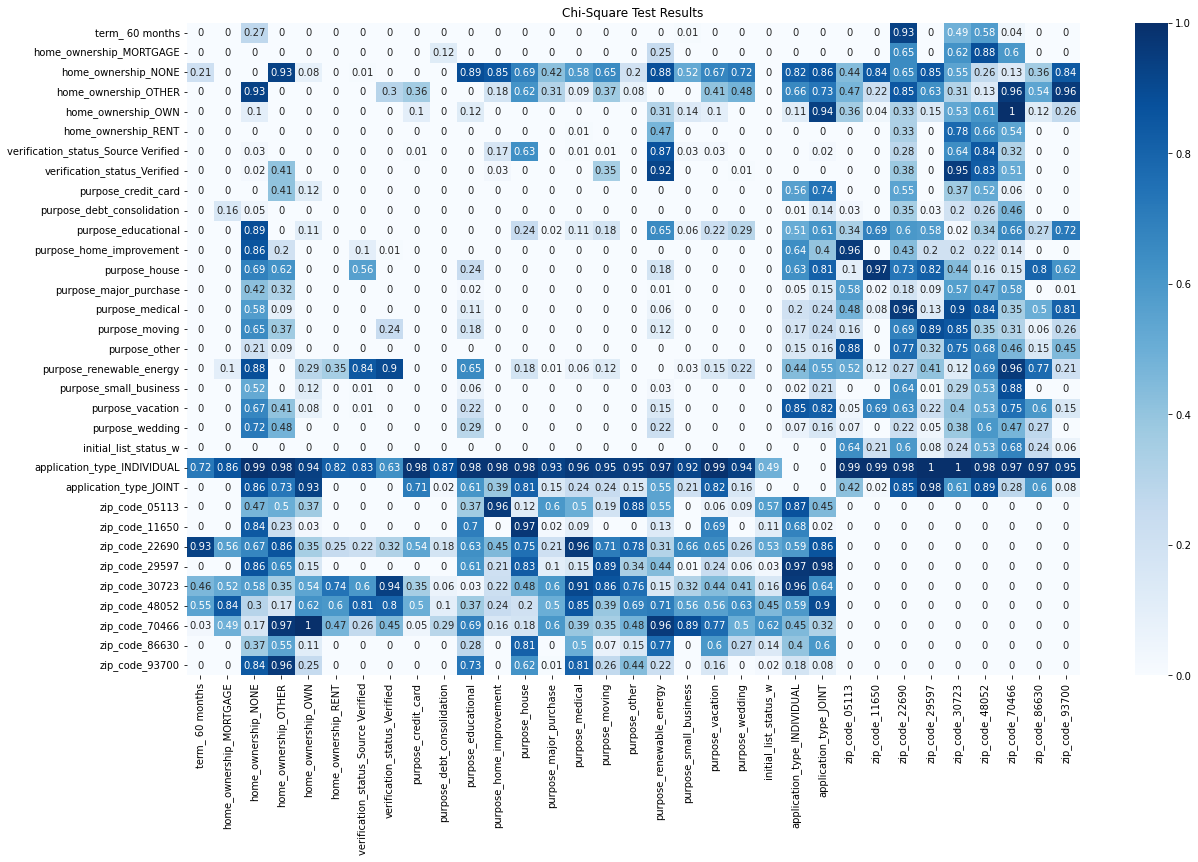

In [28]:
# Initialize the values in this matrix with 0
result = pd.DataFrame(data=[(0 for i in range(len(ohc_feats.columns))) for i in range(len(ohc_feats.columns))], 
                         columns=list(ohc_feats.columns))
result.set_index(pd.Index(list(ohc_feats.columns)), inplace=True)

# Find p_value for all columns and put them in the result matrix
for i in list(ohc_feats.columns):
    for j in list(ohc_feats.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(ohc_feats[i]).reshape(-1, 1), np.array(ohc_feats[j]).reshape(-1, 1))
            result.loc[i,j] = p_val

# Plot a heatmap
fig = plt.figure(figsize=(20,12))
sns.heatmap(result.round(2), annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.savefig('chi-square.jpeg')
plt.show()

# 3. Information Reduction

In [127]:
# Generate all the principal components
pca = PCA()
X_training_pc = pca.fit_transform(X_training)
X_training_pc.shape

(244385, 44)

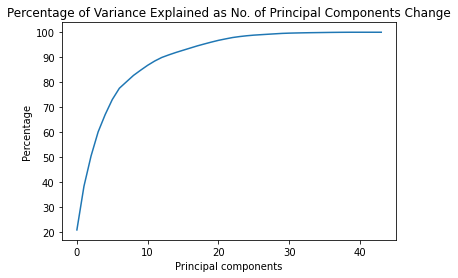

In [128]:
# Show the percentage of variance explained by the principal components 
pct_var_rate = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(pct_var_rate)
plt.xlabel('Principal components')
plt.ylabel('Percentage')
plt.title('Percentage of Variance Explained as No. of Principal Components Change')
plt.show()

In [138]:
pd.DataFrame(pca.explained_variance_.round(4), index=["P" + str(i) for i in range(1, 45)], columns=["Explained Variance"]).T

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44
Explained Variance,3.3731,2.8548,1.9728,1.5725,1.1372,0.9774,0.7381,0.4223,0.4182,0.3375,...,0.0071,0.0067,0.0058,0.0049,0.0025,0.0013,0.0007,0.0005,0.0004,0.0003


**Comments:**

- Since we do not want to use all the principal components, the question now is how many principal components we should use for regression analysis.

- The number of principal components (k) is typically determined by cross-validation and visual analysis.

- The value k is essentially a hyperparameter that we need to tune. We'll iterate over an increasing number of principal components to include in regression modeling and assess the resulting RMSE scores.

In [139]:
# Loop through different count of principal components for logistic regression
log_reg = LogisticRegression(max_iter=100)
rmse_list = []

for i in range(1, X_training_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(log_reg, 
                                      X_training_pc[:,:i], # Use first k principal components
                                      y_training,
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

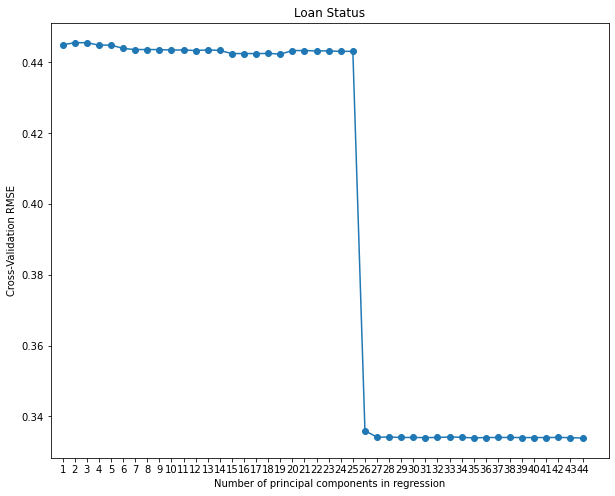

In [141]:
plt.figure(figsize = (10, 8))
plt.plot(rmse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('Cross-Validation RMSE')
plt.title('Loan Status')
plt.xlim(xmin=-1)
plt.xticks(np.arange(X_training_pc.shape[1]), np.arange(1, X_training_pc.shape[1]+1));

**Comments:**

- We see that the training set performance of PCR improves (i.e., RMSE decreases) with more principal components, in line with what we expect.

- The plot shows that the lowest cross-validation RMSE (minimum point in the plot) occurs when there are M=26 principal components.

In [142]:
# Visually determine optimal number of principal components
best_pc_num = 26

### Principal Component Regression

After determining the best number of principal components to use (i.e., M=26), we proceed to run PCR on our test dataset.

First, this is done by training a new logistic regression model on the first 26 principal components of the training set. We then use this trained model to perform prediction on the first 63 principal components of the test set.

In [143]:
# Train model on training set
log_reg_pc = LogisticRegression().fit(X_training_pc[:,:best_pc_num], y_training)

In [144]:
# Get R2 score
log_reg_pc.score(X_training_pc[:,:best_pc_num], y_training)

0.8870961802074595

In [148]:
# Define cross-validation folds
cv = RepeatedKFold(n_splits=10, random_state=rng)

pcr_score_train = -1 * cross_val_score(log_reg_pc, 
                                       X_training_pc[:,:best_pc_num], 
                                       y_training, 
                                       cv=cv, 
                                       scoring='neg_root_mean_squared_error').mean()
pcr_score_train

0.33603787818275627

In [149]:
# Get principal components of test set
X_test_pc = pca.transform(X_test)[:,:best_pc_num]
X_test_pc.shape

(79044, 26)

In [150]:
# Predict on test data
preds = log_reg_pc.predict(X_test_pc)
pcr_score_test = mean_squared_error(y_test, preds, squared=False)
pcr_score_test

0.33834973397753376

## 3.1 Elastic Net

In [69]:
# Define a model evaluation metrics table for before and after SMOTE
result_before_smote = pd.DataFrame(columns=['Classifiers', 'Accuracy', 'Recall', 'F1', 'Precision', 'Specificity', 'AUC'])
result_after_smote = pd.DataFrame(columns=['Classifiers', 'Accuracy', 'Recall', 'F1', 'Precision', 'Specificity', 'AUC'])

### Before SMOTE

#### Default model

In [70]:
# Sources: https://stackoverflow.com/questions/66787845/how-to-perform-elastic-net-for-a-classification-problem
# SAGA should be considered more advanced and used over SAG. For more information, see: https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions

# Classification with ElasticNet
enet_classifier_default = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', random_state=rng)

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy=0.89
Recall=0.99
F1=0.93
Precision=0.88
AUC=0.73


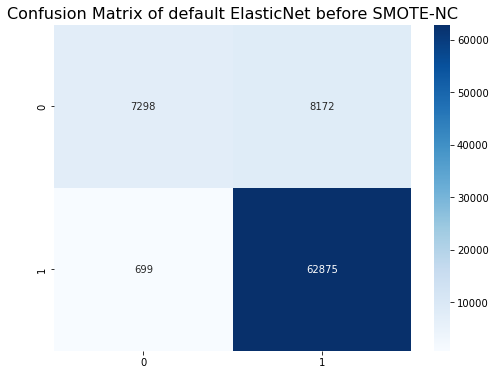

In [71]:
# Train the model
enet_model_no_smote = enet_classifier_default.fit(X_training, y_training)

# Predict on the test set
y_pred_enet_no_smote = enet_model_no_smote.predict(X_test)

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, y_pred_enet_no_smote):.2f}\nRecall={recall_score(y_test, y_pred_enet_no_smote):.2f}\nF1={f1_score(y_test, y_pred_enet_no_smote):.2f}\nPrecision={precision_score(y_test, y_pred_enet_no_smote):.2f}\nAUC={roc_auc_score(y_test, y_pred_enet_no_smote):.2f}')

# Plot the Confusion matrix
cm_enet_no_smote = confusion_matrix(y_test, y_pred_enet_no_smote)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of default ElasticNet before SMOTE-NC', size=16)
sns.heatmap(cm_enet_no_smote, annot=True, cmap='Blues', fmt='g')
plt.savefig('./Materials/cm_enet_so_smote.png')
plt.show()

In [72]:
result_before_smote = result_before_smote.append({'Classifiers': 'Default ElasticNet Classification before SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, y_pred_enet_no_smote), 
                                        'Recall': recall_score(y_test, y_pred_enet_no_smote), 
                                        'F1': f1_score(y_test, y_pred_enet_no_smote),
                                        'Precision': precision_score(y_test, y_pred_enet_no_smote),
                                        'Specificity': specificity_score(y_test, y_pred_enet_no_smote, average='weighted'),
                                        'AUC': roc_auc_score(y_test, y_pred_enet_no_smote)}, ignore_index=True)
result_before_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\1578445670.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_before_smote = result_before_smote.append({'Classifiers': 'Default ElasticNet Classification before SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification before SMOTE-NC,0.887771,0.989005,0.934104,0.884978,0.572985,0.730378


#### Tune the hyperparameters

**Comments:**

We tried 03 methods to tune the hyperparameters, GridSearchCV, LogisticRegressionCV with penalty='elasticnet' and ElasticNetCV. However, the 02 first methods took too long to finish, and because of the time limit of this this project, we decided to just use the result of ElasticNetCV for both the before and after SMOTE sets.

In [153]:
# Tune the hyperparameters using ElasticNetCV

# Define the hyperparameters
alphas = [0, 0.01, 0.1, 1, 10, 100]
ratios = np.arange(0, 1, 0.1)
enet_cv_model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv)

# Fit the ElasticNetCV model on the validation set
enet_cv_model.fit(X_validation, y_validation)

# Summarize the chosen hyperparameters
print('alpha: %f' % enet_cv_model.alpha_)
print('l1_ratio_: %f' % enet_cv_model.l1_ratio_)

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4447.703198355138, tolerance: 0.8916727346207197
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4373.121044292023, tole

alpha: 0.000000
l1_ratio_: 0.100000


C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.698e+03, tolerance: 9.922e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy=0.89
Recall=0.99
F1=0.93
Precision=0.88
AUC=0.73


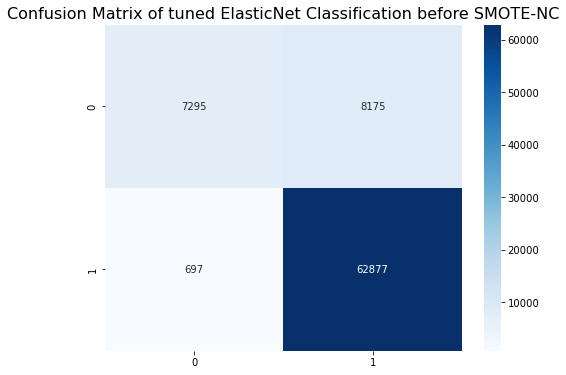

In [73]:
enet_classifier_tuned = LogisticRegression(penalty='elasticnet', l1_ratio=0.1, solver='saga', random_state=rng)

# Train the tune classifier on the training set without SMOTE
enet_model_no_smote_tuned = enet_classifier_tuned.fit(X_training, y_training)

# Predict on the test set
y_pred_enet_no_smote_tuned = enet_model_no_smote_tuned.predict(X_test)

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, y_pred_enet_no_smote_tuned):.2f}\nRecall={recall_score(y_test, y_pred_enet_no_smote_tuned):.2f}\nF1={f1_score(y_test, y_pred_enet_no_smote_tuned):.2f}\nPrecision={precision_score(y_test, y_pred_enet_no_smote_tuned):.2f}\nAUC={roc_auc_score(y_test, y_pred_enet_no_smote_tuned):.2f}')

# Plot the Confusion matrix
cm_enet_no_smote_tuned = confusion_matrix(y_test, y_pred_enet_no_smote_tuned)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of tuned ElasticNet Classification before SMOTE-NC', size=16)
sns.heatmap(cm_enet_no_smote_tuned, annot=True, cmap='Blues', fmt='g')
plt.savefig('./Materials/cm_enet_no_smote_tuned.png')
plt.show()

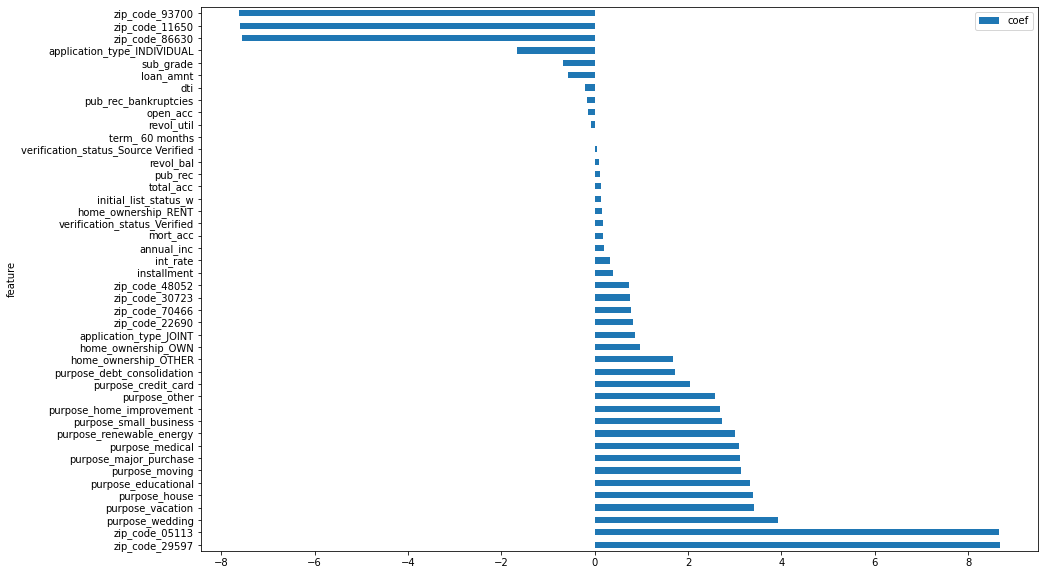

In [221]:
# Feature Importance plot
coef_no_smote_enet = enet_model_no_smote_tuned.coef_[0]
plt.rcParams["figure.figsize"] = (15, 10)

feature_importance_enet_tuned_no_smote = pd.DataFrame(X_training.columns, columns=['feature'])
feature_importance_enet_tuned_no_smote['coef'] = coef_no_smote_enet
feature_importance_enet_tuned_no_smote = feature_importance_enet_tuned_no_smote.sort_values(by = ['coef'], ascending=False) 

feature_importance_enet_tuned_no_smote = feature_importance_enet_tuned_no_smote.plot.barh(x='feature', y='coef')
plt.savefig('./Materials/coef_enet_tuned_no_smote.png')
plt.show()

In [74]:
result_before_smote = result_before_smote.append({'Classifiers': 'Tuned ElasticNet Classification before SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, y_pred_enet_no_smote_tuned), 
                                        'Recall': recall_score(y_test, y_pred_enet_no_smote_tuned), 
                                        'F1': f1_score(y_test, y_pred_enet_no_smote_tuned),
                                        'Precision': precision_score(y_test, y_pred_enet_no_smote_tuned),
                                        'Specificity': specificity_score(y_test, y_pred_enet_no_smote_tuned, average='weighted'),
                                        'AUC': roc_auc_score(y_test, y_pred_enet_no_smote_tuned)}, ignore_index=True)
result_before_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\896273942.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_before_smote = result_before_smote.append({'Classifiers': 'Tuned ElasticNet Classification before SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification before SMOTE-NC,0.887771,0.989005,0.934104,0.884978,0.572985,0.730378
1,Tuned ElasticNet Classification before SMOTE-NC,0.887759,0.989036,0.934099,0.884943,0.572836,0.730297


### After SMOTE

#### Default model

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy=0.78
Recall=0.81
F1=0.86
Precision=0.91
AUC=0.74


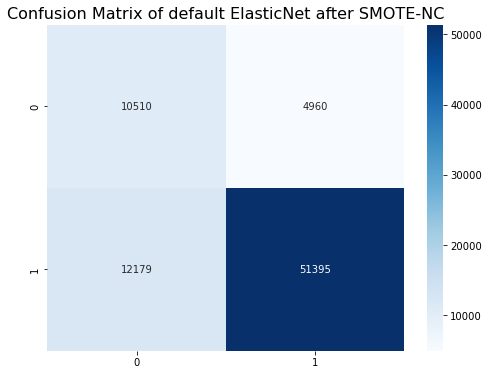

In [75]:
# Train the model
enet_model_smote = enet_classifier_default.fit(X_sm, y_sm)

# Predict on the test set
y_pred_enet_smote = enet_model_smote.predict(X_test)

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, y_pred_enet_smote):.2f}\nRecall={recall_score(y_test, y_pred_enet_smote):.2f}\nF1={f1_score(y_test, y_pred_enet_smote):.2f}\nPrecision={precision_score(y_test, y_pred_enet_smote):.2f}\nAUC={roc_auc_score(y_test, y_pred_enet_smote):.2f}')

# Plot the Confusion matrix
cm_enet_smote = confusion_matrix(y_test, y_pred_enet_smote)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of default ElasticNet after SMOTE-NC', size=16)
sns.heatmap(cm_enet_smote, annot=True, cmap='Blues', fmt='g')
plt.savefig('./Materials/cm_enet_smote.png')
plt.show()

In [76]:
result_after_smote = result_after_smote.append({'Classifiers': 'Default ElasticNet Classification after SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, y_pred_enet_smote), 
                                        'Recall': recall_score(y_test, y_pred_enet_smote), 
                                        'F1': f1_score(y_test, y_pred_enet_smote),
                                        'Precision': precision_score(y_test, y_pred_enet_smote),
                                        'Specificity': specificity_score(y_test, y_pred_enet_smote, average='weighted'),
                                        'AUC': roc_auc_score(y_test, y_pred_enet_smote)}, ignore_index=True)
result_after_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\1905094588.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_after_smote = result_after_smote.append({'Classifiers': 'Default ElasticNet Classification after SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification after SMOTE-NC,0.783171,0.808428,0.85709,0.911987,0.704636,0.743904


#### After SMOTE model with the tuned hyperparameter using ElasticNetCV above

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy=0.78
Recall=0.81
F1=0.86
Precision=0.91
AUC=0.74


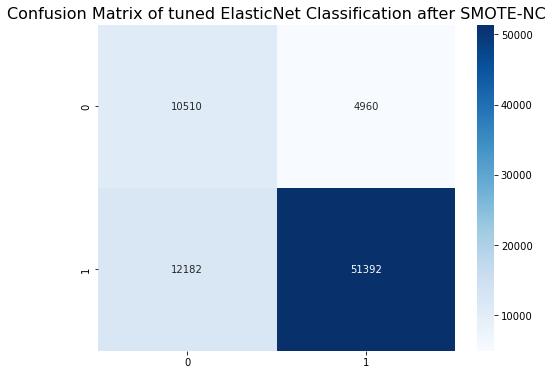

In [77]:
# Train the tuned classifier on the training set with SMOTE
enet_model_smote_tuned = enet_classifier_tuned.fit(X_sm, y_sm)

# Predict on the test set
y_pred_enet_smote_tuned = enet_model_smote_tuned.predict(X_test)

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, y_pred_enet_smote_tuned):.2f}\nRecall={recall_score(y_test, y_pred_enet_smote_tuned):.2f}\nF1={f1_score(y_test, y_pred_enet_smote_tuned):.2f}\nPrecision={precision_score(y_test, y_pred_enet_smote_tuned):.2f}\nAUC={roc_auc_score(y_test, y_pred_enet_smote_tuned):.2f}')

# Plot the Confusion matrix
cm_enet_smote_tuned = confusion_matrix(y_test, y_pred_enet_smote_tuned)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of tuned ElasticNet Classification after SMOTE-NC', size=16)
sns.heatmap(cm_enet_smote_tuned, annot=True, cmap='Blues', fmt='g')
plt.savefig('./Materials/cm_enet_smote_tuned.png')
plt.show()

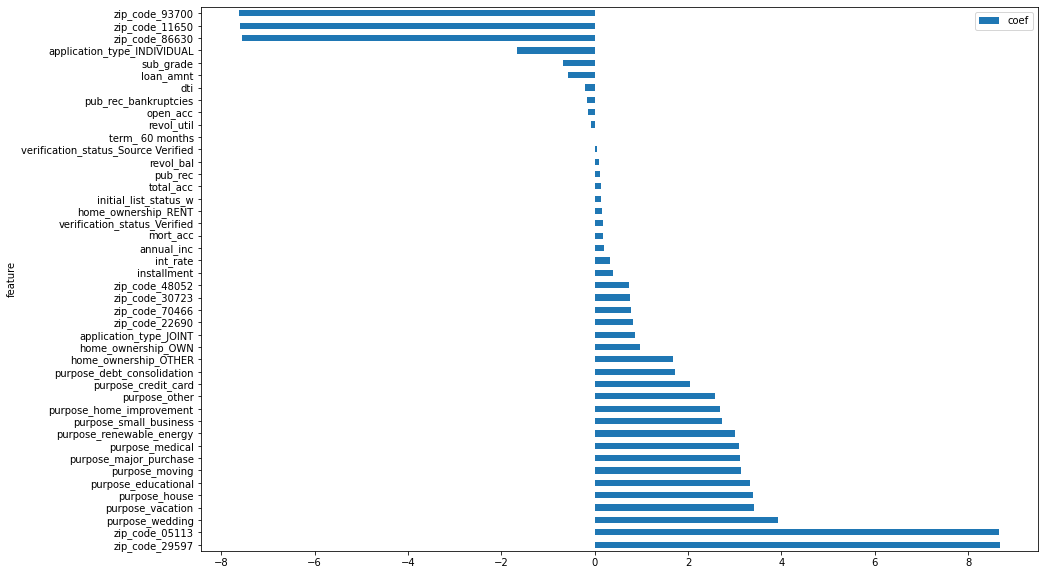

In [222]:
# Feature Importance plot
coef_smote_enet = enet_model_smote_tuned.coef_[0]
plt.rcParams["figure.figsize"] = (15, 10)

feature_importance_enet_tuned_smote = pd.DataFrame(X_sm.columns, columns=['feature'])
feature_importance_enet_tuned_smote['coef'] = coef_smote_enet
feature_importance_enet_tuned_smote = feature_importance_enet_tuned_smote.sort_values(by = ['coef'], ascending=False) 

feature_importance_enet_tuned_smote = feature_importance_enet_tuned_smote.plot.barh(x='feature', y='coef')
plt.savefig('./Materials/coef_enet_tuned_smote.png')
plt.show()

In [78]:
result_after_smote = result_after_smote.append({'Classifiers': 'Tuned ElasticNet Classification after SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, y_pred_enet_smote_tuned), 
                                        'Recall': recall_score(y_test, y_pred_enet_smote_tuned), 
                                        'F1': f1_score(y_test, y_pred_enet_smote_tuned),
                                        'Precision': precision_score(y_test, y_pred_enet_smote_tuned),
                                        'Specificity': specificity_score(y_test, y_pred_enet_smote_tuned, average='weighted'),
                                        'AUC': roc_auc_score(y_test, y_pred_enet_smote_tuned)}, ignore_index=True)
result_after_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\4174114128.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_after_smote = result_after_smote.append({'Classifiers': 'Tuned ElasticNet Classification after SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification after SMOTE-NC,0.783171,0.808428,0.85709,0.911987,0.704636,0.743904
1,Tuned ElasticNet Classification after SMOTE-NC,0.783133,0.808381,0.857062,0.911982,0.704627,0.74388


#### After SMOTE model with Polynomial Features

In [79]:
# Set up the polynomial features
poly = PolynomialFeatures(2, interaction_only=False)
X_poly_train = poly.fit_transform(X_sm)
X_poly_test = poly.fit_transform(X_test)
print(X_poly_train.shape)
print(X_poly_test.shape)

(392040, 1035)
(79044, 1035)


In [200]:
# Define function to keep the attributes of Polynomial Features DataFrame
# Source: https://stackoverflow.com/questions/36728287/sklearn-preprocessing-polynomialfeatures-how-to-keep-column-names-headers-of
def PolynomialFeatures_labeled(input_df, power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

In [201]:
X_poly_train_df = PolynomialFeatures_labeled(X_sm, 2)

In [203]:
# Concatenate X_poly_train and y_training to run Autometrics on OxMetrics
poly_df = pd.concat([X_poly_train_df, y_training], axis=1) # aixs=1 concatenate along columns to make horizontal database, =0 otherwise
poly_df.head()

,Constant Term,loan_amnt^1,int_rate^1,installment^1,sub_grade^1,annual_inc^1,dti^1,open_acc^1,pub_rec^1,revol_bal^1,...,zip_code_48052^1 x zip_code_70466^1,zip_code_48052^1 x zip_code_86630^1,zip_code_48052^1 x zip_code_93700^1,zip_code_70466^2,zip_code_70466^1 x zip_code_86630^1,zip_code_70466^1 x zip_code_93700^1,zip_code_86630^2,zip_code_86630^1 x zip_code_93700^1,zip_code_93700^2,loan_status
0,1.0,0.018534,0.137062,0.231107,3.2,-1.001508,-1.108392,0.171575,-0.417433,-0.069257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1.0,1.121684,0.809669,0.619202,3.8,-0.480941,-0.873830,0.171575,-0.417433,0.418945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.141106,1.314123,-0.125327,5.2,-0.452021,0.043434,-0.443308,-0.417433,-0.408410,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,2.347405,-0.344972,2.764162,2.4,1.745929,-0.567664,-1.263151,-0.417433,-0.534649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,-1.109130,0.143789,-1.063104,3.0,-0.133896,0.164419,-1.058190,-0.417433,-0.442018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [204]:
# Save the Polynomial Features as csv file to run on OxMetrics
poly_df.to_csv('./Data/poly_df')

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy=0.79
Recall=0.82
F1=0.86
Precision=0.91
AUC=0.75


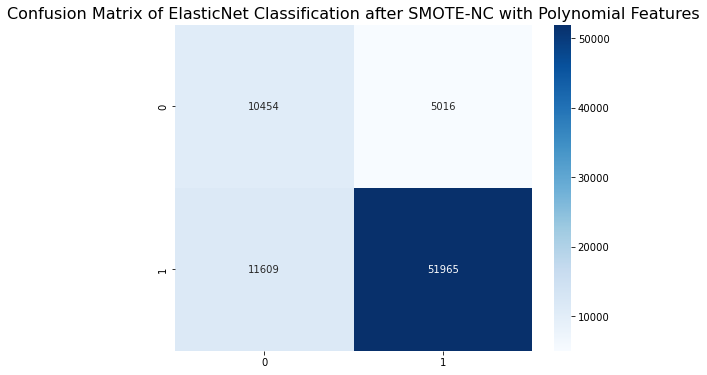

In [80]:
# Train the tuned classifier on the training set with SMOTE
enet_model_smote_poly = enet_classifier_tuned.fit(X_poly_train, y_sm)

# Predict on the test set
y_pred_enet_smote_poly = enet_model_smote_poly.predict(X_poly_test)

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, y_pred_enet_smote_poly):.2f}\nRecall={recall_score(y_test, y_pred_enet_smote_poly):.2f}\nF1={f1_score(y_test, y_pred_enet_smote_poly):.2f}\nPrecision={precision_score(y_test, y_pred_enet_smote_poly):.2f}\nAUC={roc_auc_score(y_test, y_pred_enet_smote_poly):.2f}')

# Plot the Confusion matrix
cm_enet_smote_poly = confusion_matrix(y_test, y_pred_enet_smote_poly)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of ElasticNet Classification after SMOTE-NC with Polynomial Features', size=16)
sns.heatmap(cm_enet_smote_poly, annot=True, cmap='Blues', fmt='g')
plt.savefig('./Materials/cm_enet_smote_poly.png')
plt.show()

In [81]:
result_after_smote = result_after_smote.append({'Classifiers': 'ElasticNet Classification after SMOTE-NC with Polynomial Features',
                                        'Accuracy': accuracy_score(y_test, y_pred_enet_smote_poly), 
                                        'Recall': recall_score(y_test, y_pred_enet_smote_poly), 
                                        'F1': f1_score(y_test, y_pred_enet_smote_poly),
                                        'Precision': precision_score(y_test, y_pred_enet_smote_poly),
                                        'Specificity': specificity_score(y_test, y_pred_enet_smote_poly, average='weighted'),
                                        'AUC': roc_auc_score(y_test, y_pred_enet_smote_poly)}, ignore_index=True)
result_after_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\1761740429.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_after_smote = result_after_smote.append({'Classifiers': 'ElasticNet Classification after SMOTE-NC with Polynomial Features',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification after SMOTE-NC,0.783171,0.808428,0.85709,0.911987,0.704636,0.743904
1,Tuned ElasticNet Classification after SMOTE-NC,0.783133,0.808381,0.857062,0.911982,0.704627,0.74388
2,ElasticNet Classification after SMOTE-NC with ...,0.789674,0.817394,0.862096,0.911971,0.703479,0.746577


C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


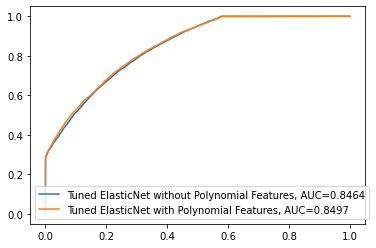

In [82]:
# ROC curve with and without Polynomial features
## Set up the plotting area
plt.figure(0).clf()

## Plot ROC curve for ElasticNet without Polynomial features
enet_model_smote_tuned = enet_classifier_tuned.fit(X_sm, y_sm)
y_pred_proba_enet = enet_model_smote_tuned.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_enet)
auc = round(roc_auc_score(y_test, y_pred_proba_enet), 4)
plt.plot(fpr, tpr, label='Tuned ElasticNet without Polynomial Features, AUC='+str(auc))

## Plot ROC curve for ElasticNet with Polynomial features
enet_model_smote_poly = enet_classifier_tuned.fit(X_poly_train, y_sm)
y_pred_proba_enet_poly = enet_model_smote_poly.predict_proba(X_poly_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_enet_poly)
auc = round(roc_auc_score(y_test, y_pred_proba_enet_poly), 4)
plt.plot(fpr, tpr, label='Tuned ElasticNet with Polynomial Features, AUC='+str(auc))

## Add legend
plt.legend()

## Save and show figure
plt.savefig('./Materials/roc_compare_poly.png')
plt.show()

## 3.3 Autometrics

We first run Autometrics on Oxmetrics and then used the selected variables to test the Logistic Classification models' performances for both before and after SMOTE datasets.

### Before SMOTE

In [83]:
# List of the selected variables using OxMetrics
autometrics_var_no_sm = ['int_rate', 'installment', 'sub_grade', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'term_ 60 months', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_small_business', 'purpose_wedding', 'application_type_JOINT', 'zip_code_11650', 'zip_code_22690', 'zip_code_30723', 'zip_code_48052', 'zip_code_70466', 'zip_code_86630', 'zip_code_93700']

In [84]:
# Fit the default Logistic Regression on the training set
autometrics_no_smote = LogisticRegression()
autometrics_no_smote.fit(X_training[autometrics_var_no_sm], y_training.values.ravel())

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy=0.89
Recall=0.99
F1=0.93
Precision=0.88
AUC=0.73


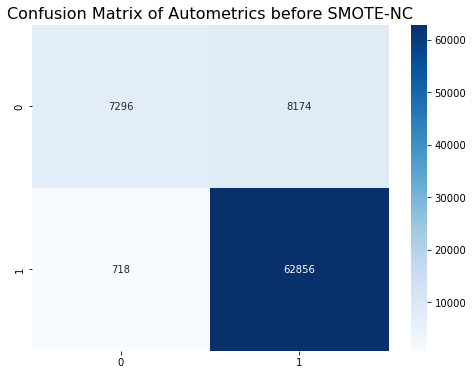

In [85]:
# Predict on the test set
pred_autometrics_no_smote = autometrics_no_smote.predict(X_test[autometrics_var_no_sm])

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, pred_autometrics_no_smote):.2f}\nRecall={recall_score(y_test, pred_autometrics_no_smote):.2f}\nF1={f1_score(y_test, pred_autometrics_no_smote):.2f}\nPrecision={precision_score(y_test, pred_autometrics_no_smote):.2f}\nAUC={roc_auc_score(y_test, pred_autometrics_no_smote):.2f}')

# Plot the Confusion matrix
cm_autometrics_no_smote = confusion_matrix(y_test, pred_autometrics_no_smote)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of Autometrics before SMOTE-NC', size=16)
sns.heatmap(cm_autometrics_no_smote, annot=True, cmap='Blues', fmt='g')
plt.savefig('./Materials/cm_auto_no_smote')
plt.show()

In [86]:
result_before_smote = result_before_smote.append({'Classifiers': 'Autometrics before SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, pred_autometrics_no_smote), 
                                        'Recall': recall_score(y_test, pred_autometrics_no_smote), 
                                        'F1': f1_score(y_test, pred_autometrics_no_smote),
                                        'Precision': precision_score(y_test, pred_autometrics_no_smote),
                                        'Specificity': specificity_score(y_test, pred_autometrics_no_smote, average='weighted'),
                                        'AUC': roc_auc_score(y_test, pred_autometrics_no_smote)}, ignore_index=True)
result_before_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\1965992899.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_before_smote = result_before_smote.append({'Classifiers': 'Autometrics before SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification before SMOTE-NC,0.887771,0.989005,0.934104,0.884978,0.572985,0.730378
1,Tuned ElasticNet Classification before SMOTE-NC,0.887759,0.989036,0.934099,0.884943,0.572836,0.730297
2,Autometrics before SMOTE-NC,0.887506,0.988706,0.93394,0.884922,0.572823,0.730164


### After SMOTE

In [87]:
# List of the selected variables using OxMetrics
autometrics_var_sm = ['int_rate', 'installment', 'sub_grade', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'term_ 60 months', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'initial_list_status_w', 'application_type_INDIVIDUAL', 'zip_code_05113', 'zip_code_11650', 'zip_code_22690', 'zip_code_29597', 'zip_code_30723', 'zip_code_48052', 'zip_code_70466', 'zip_code_86630', 'zip_code_93700']

In [88]:
# Fit the default Logistic Regression on the SMOTE set
autometrics_smote = LogisticRegression()
autometrics_smote.fit(X_sm[autometrics_var_sm], y_sm.values.ravel())

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy=0.78
Recall=0.81
F1=0.86
Precision=0.91
AUC=0.74


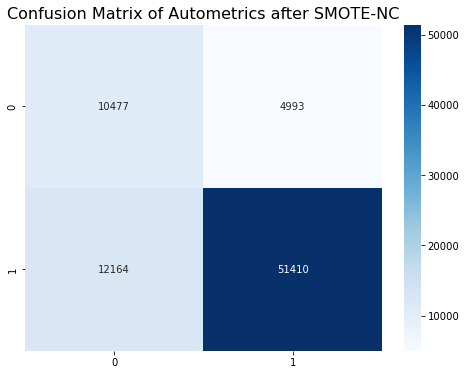

In [89]:
# Predict on the test set
pred_autometrics_smote = autometrics_smote.predict(X_test[autometrics_var_sm])

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, pred_autometrics_smote):.2f}\nRecall={recall_score(y_test, pred_autometrics_smote):.2f}\nF1={f1_score(y_test, pred_autometrics_smote):.2f}\nPrecision={precision_score(y_test, pred_autometrics_smote):.2f}\nAUC={roc_auc_score(y_test, pred_autometrics_smote):.2f}')

# Plot the Confusion matrix
cm_autometrics_smote = confusion_matrix(y_test, pred_autometrics_smote)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of Autometrics after SMOTE-NC', size=16)
sns.heatmap(cm_autometrics_smote, annot=True, cmap='Blues', fmt='g')
plt.savefig('./Materials/cm_auto_smote')
plt.show()

In [90]:
result_after_smote = result_after_smote.append({'Classifiers': 'Autometrics after SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, pred_autometrics_smote), 
                                        'Recall': recall_score(y_test, pred_autometrics_smote), 
                                        'F1': f1_score(y_test, pred_autometrics_smote),
                                        'Precision': precision_score(y_test, pred_autometrics_smote),
                                        'Specificity': specificity_score(y_test, pred_autometrics_smote, average='weighted'),
                                        'AUC': roc_auc_score(y_test, pred_autometrics_smote)}, ignore_index=True)
result_after_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\1656648011.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_after_smote = result_after_smote.append({'Classifiers': 'Autometrics after SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification after SMOTE-NC,0.783171,0.808428,0.85709,0.911987,0.704636,0.743904
1,Tuned ElasticNet Classification after SMOTE-NC,0.783133,0.808381,0.857062,0.911982,0.704627,0.74388
2,ElasticNet Classification after SMOTE-NC with ...,0.789674,0.817394,0.862096,0.911971,0.703479,0.746577
3,Autometrics after SMOTE-NC,0.782944,0.808664,0.856998,0.911476,0.702967,0.742955


# 4. Prediction Models

## 4.1 Logistic Regressions

### Before SMOTE

In [91]:
# Fit the default Logistic Regression on the training set
log_reg_no_smote = LogisticRegression()
log_reg_no_smote.fit(X_training, y_training.values.ravel())

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy=0.89
Recall=0.99
F1=0.93
Precision=0.88
AUC=0.73


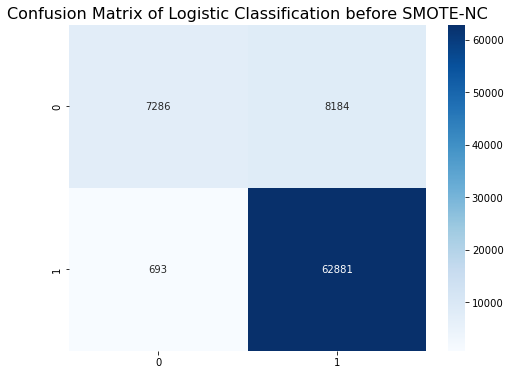

In [92]:
# Predict on the test set
pred_log_no_smote = log_reg_no_smote.predict(X_test)

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, pred_log_no_smote):.2f}\nRecall={recall_score(y_test, pred_log_no_smote):.2f}\nF1={f1_score(y_test, pred_log_no_smote):.2f}\nPrecision={precision_score(y_test, pred_log_no_smote):.2f}\nAUC={roc_auc_score(y_test, pred_log_no_smote):.2f}')

# Plot the Confusion matrix
cm_log_no_smote = confusion_matrix(y_test, pred_log_no_smote)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of Logistic Classification before SMOTE-NC', size=16)
sns.heatmap(cm_log_no_smote, annot=True, cmap='Blues', fmt='g')
plt.savefig('./Materials/cm_log_no_smote')
plt.show()

In [93]:
result_before_smote = result_before_smote.append({'Classifiers': 'Logistic Classification before SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, pred_log_no_smote), 
                                        'Recall': recall_score(y_test, pred_log_no_smote), 
                                        'F1': f1_score(y_test, pred_log_no_smote),
                                        'Precision': precision_score(y_test, pred_log_no_smote),
                                        'Specificity': specificity_score(y_test, pred_log_no_smote, average='weighted'),
                                        'AUC': roc_auc_score(y_test, pred_log_no_smote)}, ignore_index=True)
result_before_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\1323480339.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_before_smote = result_before_smote.append({'Classifiers': 'Logistic Classification before SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification before SMOTE-NC,0.887771,0.989005,0.934104,0.884978,0.572985,0.730378
1,Tuned ElasticNet Classification before SMOTE-NC,0.887759,0.989036,0.934099,0.884943,0.572836,0.730297
2,Autometrics before SMOTE-NC,0.887506,0.988706,0.93394,0.884922,0.572823,0.730164
3,Logistic Classification before SMOTE-NC,0.887695,0.989099,0.934068,0.884838,0.57238,0.730038


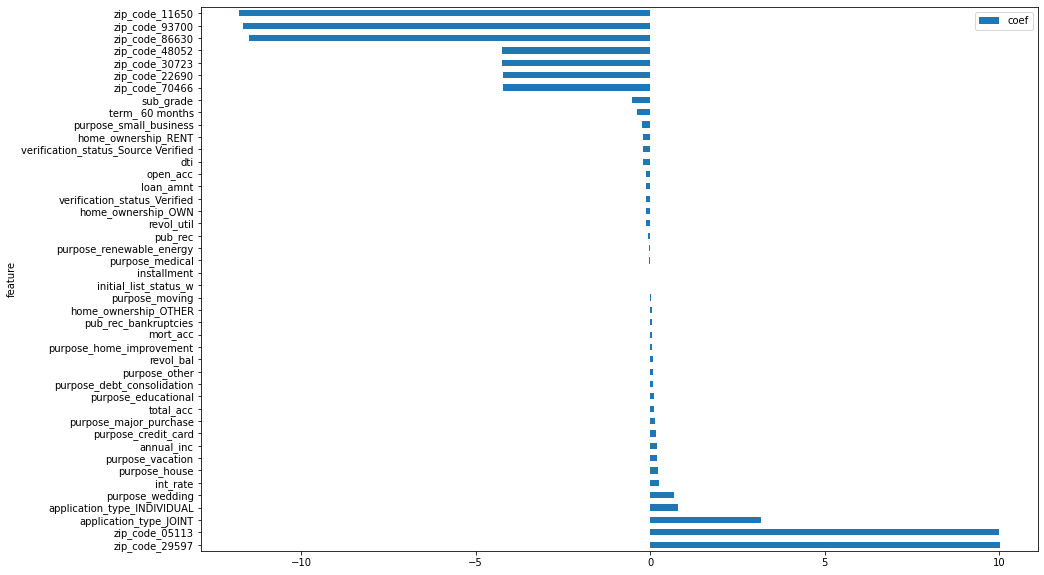

In [178]:
# Feature Importance plot
coef_no_smote = log_reg_no_smote.coef_[0]
plt.rcParams["figure.figsize"] = (15, 10)

feature_importance_log_reg_no_smote = pd.DataFrame(X_training.columns, columns=['feature'])
feature_importance_log_reg_no_smote['coef'] = coef_no_smote
feature_importance_log_reg_no_smote = feature_importance_log_reg_no_smote.sort_values(by = ['coef'], ascending=False) 

feature_importance_log_reg_no_smote = feature_importance_log_reg_no_smote.plot.barh(x='feature', y='coef')
plt.savefig('./Materials/coef_log_no_smote.png')
plt.show()

### After SMOTE

In [94]:
# Fit the default Logistic Regression on the SMOTE set
log_reg_smote = LogisticRegression()
log_reg_smote.fit(X_sm, y_sm.values.ravel())

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy=0.78
Recall=0.81
F1=0.86
Precision=0.91
AUC=0.74


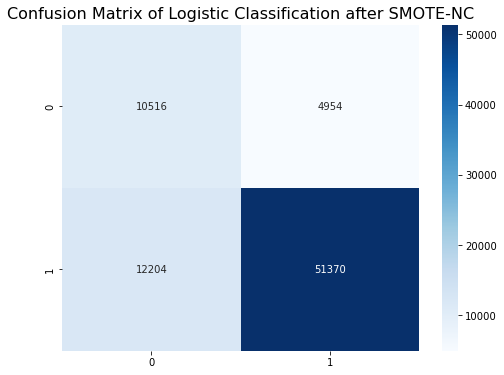

In [95]:
# Predict on the test set
pred_log_smote = log_reg_smote.predict(X_test)

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, pred_log_smote):.2f}\nRecall={recall_score(y_test, pred_log_smote):.2f}\nF1={f1_score(y_test, pred_log_smote):.2f}\nPrecision={precision_score(y_test, pred_log_smote):.2f}\nAUC={roc_auc_score(y_test, pred_log_smote):.2f}')

# Plot the Confusion matrix
cm_log_smote = confusion_matrix(y_test, pred_log_smote)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of Logistic Classification after SMOTE-NC', size=16)
sns.heatmap(cm_log_smote, annot=True, cmap='Blues', fmt='g')
plt.savefig('Materials/cm_log_smote.png')
plt.show()

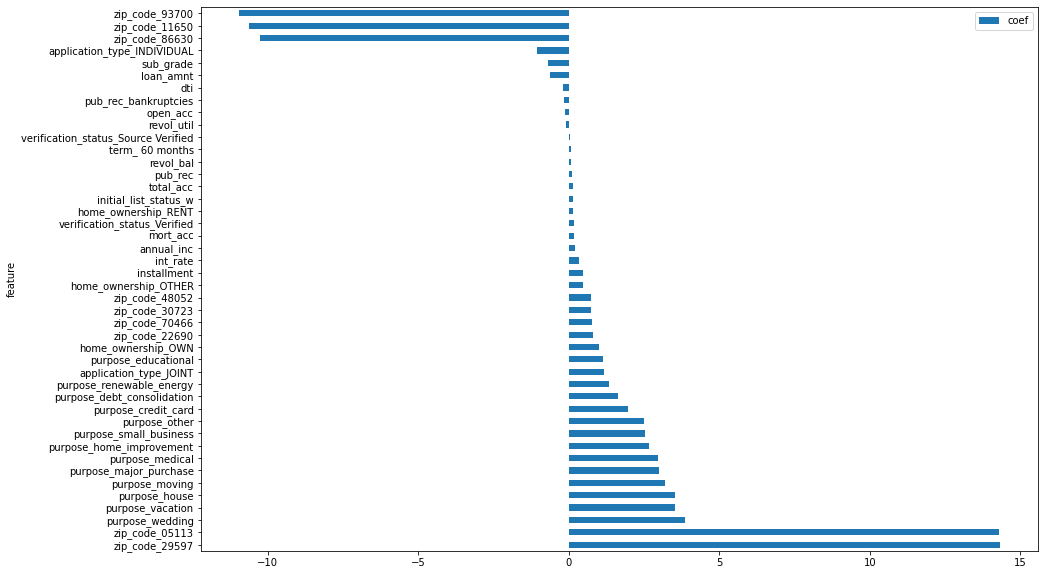

In [177]:
# Feature Importance plot
coef_smote = log_reg_smote.coef_[0]
plt.rcParams["figure.figsize"] = (15, 10)

feature_importance_log_reg_smote = pd.DataFrame(X_sm.columns, columns=['feature'])
feature_importance_log_reg_smote['coef'] = coef_smote
feature_importance_log_reg_smote = feature_importance_log_reg_smote.sort_values(by = ['coef'], ascending=False) 

feature_importance_log_reg_smote = feature_importance_log_reg_smote.plot.barh(x='feature', y='coef')
plt.savefig('./Materials/coef_log_smote.jpeg')
plt.show()

In [96]:
result_after_smote = result_after_smote.append({'Classifiers': 'Logistic Classification after SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, pred_log_smote), 
                                        'Recall': recall_score(y_test, pred_log_smote), 
                                        'F1': f1_score(y_test, pred_log_smote),
                                        'Precision': precision_score(y_test, pred_log_smote),
                                        'Specificity': specificity_score(y_test, pred_log_smote, average='weighted'),
                                        'AUC': roc_auc_score(y_test, pred_log_smote)}, ignore_index=True)
result_after_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\3408777955.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_after_smote = result_after_smote.append({'Classifiers': 'Logistic Classification after SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification after SMOTE-NC,0.783171,0.808428,0.85709,0.911987,0.704636,0.743904
1,Tuned ElasticNet Classification after SMOTE-NC,0.783133,0.808381,0.857062,0.911982,0.704627,0.74388
2,ElasticNet Classification after SMOTE-NC with ...,0.789674,0.817394,0.862096,0.911971,0.703479,0.746577
3,Autometrics after SMOTE-NC,0.782944,0.808664,0.856998,0.911476,0.702967,0.742955
4,Logistic Classification after SMOTE-NC,0.782931,0.808035,0.856895,0.912045,0.704871,0.743901


#### Tune the hyperparameter

In [97]:
# Perform Grid Search Cross Validation for Logistic Classification Model
log_reg_model = LogisticRegression(max_iter=10000)

c_values = [100, 10, 1.0, 0.1, 0.01]

# Define grid search
grid = dict(C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1) # Here we use RepeatedStratifiedKFold because we have imbalanced dataset (Sources: https://stackoverflow.com/questions/71181291/differences-between-repeatedstratifiedkfold-and-stratifiedkfold-in-sklearn, https://stackoverflow.com/questions/70849127/train-validation-testing-sets-for-imbalanced-dataset/70850584#70850584)
grid_search = GridSearchCV(estimator=log_reg_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
# Perform grid search on the validation set
grid_result = grid_search.fit(X_validation, y_validation.values.ravel())

# Summarize the results
print("Best hyperparameter with the score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best hyperparameter with the score: 0.935111 using {'C': 0.1}
0.934777 (0.000966) with: {'C': 100}
0.934795 (0.000986) with: {'C': 10}
0.934926 (0.000937) with: {'C': 1.0}
0.935111 (0.000912) with: {'C': 0.1}
0.934647 (0.000825) with: {'C': 0.01}


In [98]:
# Fit the Logistic Regression on the tuned hyperparameter
log_reg_tuned = grid_result.best_estimator_
log_reg_tuned.fit(X_sm, y_sm.values.ravel())

LogisticRegression(C=0.1, max_iter=10000)

Accuracy=0.78
Recall=0.81
F1=0.86
Precision=0.91
AUC=0.74


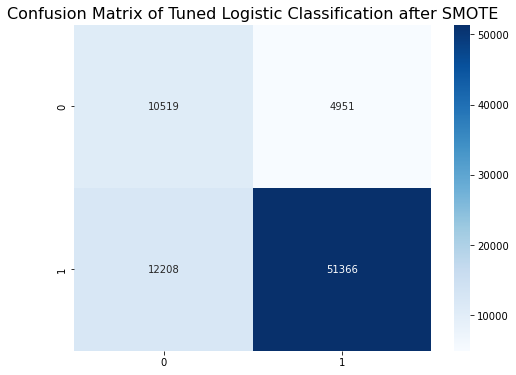

In [99]:
# Predict on the test set
pred_log_tuned = log_reg_tuned.predict(X_test)

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, pred_log_tuned):.2f}\nRecall={recall_score(y_test, pred_log_tuned):.2f}\nF1={f1_score(y_test, pred_log_tuned):.2f}\nPrecision={precision_score(y_test, pred_log_tuned):.2f}\nAUC={roc_auc_score(y_test, pred_log_tuned):.2f}')

# Plot the Confusion matrix
cm_log_tuned = confusion_matrix(y_test, pred_log_tuned)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of Tuned Logistic Classification after SMOTE', size=16)
sns.heatmap(cm_log_tuned, annot=True, cmap='Blues', fmt='g');
plt.savefig('./Materials/cm_log_tunned.png')
plt.show()

In [100]:
result_after_smote = result_after_smote.append({'Classifiers': 'Tuned Logistic Classification after SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, pred_log_tuned), 
                                        'Recall': recall_score(y_test, pred_log_tuned), 
                                        'F1': f1_score(y_test, pred_log_tuned),
                                        'Precision': precision_score(y_test, pred_log_tuned),
                                        'Specificity': specificity_score(y_test, pred_log_tuned, average='weighted'),
                                        'AUC': roc_auc_score(y_test, pred_log_tuned)}, ignore_index=True)
result_after_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\125291092.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_after_smote = result_after_smote.append({'Classifiers': 'Tuned Logistic Classification after SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification after SMOTE-NC,0.783171,0.808428,0.85709,0.911987,0.704636,0.743904
1,Tuned ElasticNet Classification after SMOTE-NC,0.783133,0.808381,0.857062,0.911982,0.704627,0.74388
2,ElasticNet Classification after SMOTE-NC with ...,0.789674,0.817394,0.862096,0.911971,0.703479,0.746577
3,Autometrics after SMOTE-NC,0.782944,0.808664,0.856998,0.911476,0.702967,0.742955
4,Logistic Classification after SMOTE-NC,0.782931,0.808035,0.856895,0.912045,0.704871,0.743901
5,Tuned Logistic Classification after SMOTE-NC,0.782918,0.807972,0.856878,0.912087,0.705015,0.743967


#### After SMOTE With Polynomial Features

In [101]:
# Fit the default Logistic Regression with polynomial features
log_reg_poly = LogisticRegression()
log_reg_poly.fit(X_poly_train, y_sm.values.ravel())

C:\Users\AMSE\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Accuracy=0.79
Recall=0.81
F1=0.86
Precision=0.91
AUC=0.74


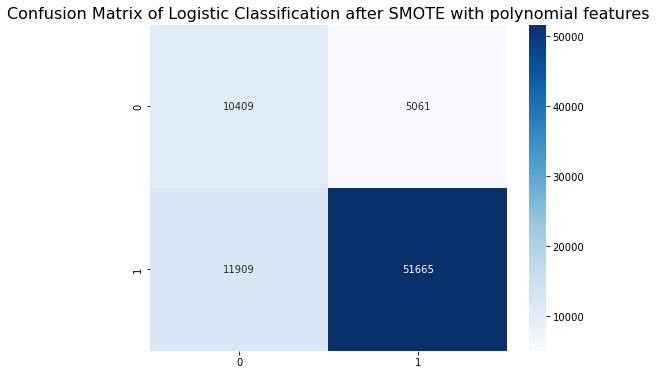

In [102]:
# Predict on the test set
pred_log_poly = log_reg_poly.predict(X_poly_test)

# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, pred_log_poly):.2f}\nRecall={recall_score(y_test, pred_log_poly):.2f}\nF1={f1_score(y_test, pred_log_poly):.2f}\nPrecision={precision_score(y_test, pred_log_poly):.2f}\nAUC={roc_auc_score(y_test, pred_log_poly):.2f}')

# Plot the Confusion matrix
cm_log_poly = confusion_matrix(y_test, pred_log_poly)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of Logistic Classification after SMOTE with polynomial features', size=16)
sns.heatmap(cm_log_poly, annot=True, cmap='Blues', fmt='g');
plt.savefig('./Materials/cm_log_poly.png')
plt.show()

In [103]:
result_after_smote = result_after_smote.append({'Classifiers': 'Logistic Classification after SMOTE-NC with polynomial features',
                                        'Accuracy': accuracy_score(y_test, pred_log_poly), 
                                        'Recall': recall_score(y_test, pred_log_poly), 
                                        'F1': f1_score(y_test, pred_log_poly),
                                        'Precision': precision_score(y_test, pred_log_poly),
                                        'Specificity': specificity_score(y_test, pred_log_poly, average='weighted'),
                                        'AUC': roc_auc_score(y_test, pred_log_poly)}, ignore_index=True)
result_after_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\1651156245.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_after_smote = result_after_smote.append({'Classifiers': 'Logistic Classification after SMOTE-NC with polynomial features',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification after SMOTE-NC,0.783171,0.808428,0.85709,0.911987,0.704636,0.743904
1,Tuned ElasticNet Classification after SMOTE-NC,0.783133,0.808381,0.857062,0.911982,0.704627,0.74388
2,ElasticNet Classification after SMOTE-NC with ...,0.789674,0.817394,0.862096,0.911971,0.703479,0.746577
3,Autometrics after SMOTE-NC,0.782944,0.808664,0.856998,0.911476,0.702967,0.742955
4,Logistic Classification after SMOTE-NC,0.782931,0.808035,0.856895,0.912045,0.704871,0.743901
5,Tuned Logistic Classification after SMOTE-NC,0.782918,0.807972,0.856878,0.912087,0.705015,0.743967
6,Logistic Classification after SMOTE-NC with po...,0.785309,0.812675,0.858936,0.910782,0.700216,0.742763


## 4.2 Random Forest

### Before SMOTE

In [104]:
# Fit the default Random Forest Classifier
rfc = RandomForestClassifier(random_state=rng)

# Fit on the training set without SMOTE
rf_no_smote = rfc.fit(X_training, y_training.values.ravel())

# Predict on the test set
pred_rf_no_sm = rf_no_smote.predict(X_test)

Accuracy=0.89
Recall=0.99
F1=0.93
Precision=0.88
AUC=0.72


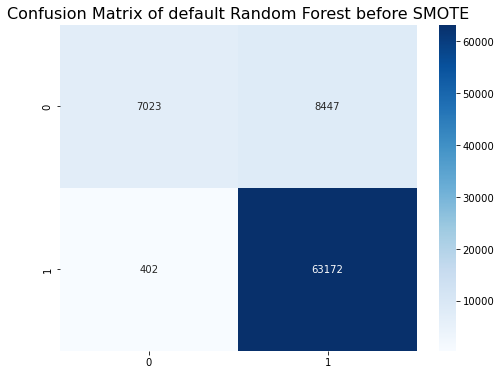

In [105]:
# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, pred_rf_no_sm):.2f}\nRecall={recall_score(y_test, pred_rf_no_sm):.2f}\nF1={f1_score(y_test, pred_rf_no_sm):.2f}\nPrecision={precision_score(y_test, pred_rf_no_sm):.2f}\nAUC={roc_auc_score(y_test, pred_rf_no_sm):.2f}')

# Plot the Confusion matrix
cm_rf_no_smote = confusion_matrix(y_test, pred_rf_no_sm)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of default Random Forest before SMOTE', size=16)
sns.heatmap(cm_rf_no_smote, annot=True, cmap='Blues', fmt='g');
plt.savefig('./Materials/cm_rf_no_smote.png')
plt.show()

In [106]:
result_before_smote = result_before_smote.append({'Classifiers': 'Random Forest before SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, pred_rf_no_sm), 
                                        'Recall': recall_score(y_test, pred_rf_no_sm), 
                                        'F1': f1_score(y_test, pred_rf_no_sm),
                                        'Precision': precision_score(y_test, pred_rf_no_sm),
                                        'Specificity': specificity_score(y_test, pred_rf_no_sm, average='weighted'),
                                        'AUC': roc_auc_score(y_test, pred_rf_no_sm)}, ignore_index=True)
result_before_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_5156\3481012490.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_before_smote = result_before_smote.append({'Classifiers': 'Random Forest before SMOTE-NC',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification before SMOTE-NC,0.887771,0.989005,0.934104,0.884978,0.572985,0.730378
1,Tuned ElasticNet Classification before SMOTE-NC,0.887759,0.989036,0.934099,0.884943,0.572836,0.730297
2,Autometrics before SMOTE-NC,0.887506,0.988706,0.93394,0.884922,0.572823,0.730164
3,Logistic Classification before SMOTE-NC,0.887695,0.989099,0.934068,0.884838,0.57238,0.730038
4,Random Forest before SMOTE-NC,0.88805,0.993677,0.934545,0.882056,0.559602,0.723826


In [110]:
# Random Hyperparameter Grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [112]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=rng, n_jobs=-1)
# Fit the random search model on the validation set
rf_random.fit(X_validation, y_validation)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=RandomState(MT19937) at 0x1CB912ED040,
                   verbose=2)

In [113]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

**Comments:**

From these results, we should be able to narrow the range of values for each hyperparameter.

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

It took too long to tune the hyperparameters, and we've run out of time, so we have no choice but to skip this part.

### After SMOTE

In [109]:
# Fit the default Random Forest Classifier
rfc = RandomForestClassifier(random_state=rng)

# Fit on the training set without SMOTE
rf_smote = rfc.fit(X_sm, y_sm.values.ravel())

# Predict on the test set
pred_rf_sm = rf_smote.predict(X_test)

Accuracy=0.86
Recall=0.92
F1=0.91
Precision=0.90
AUC=0.75


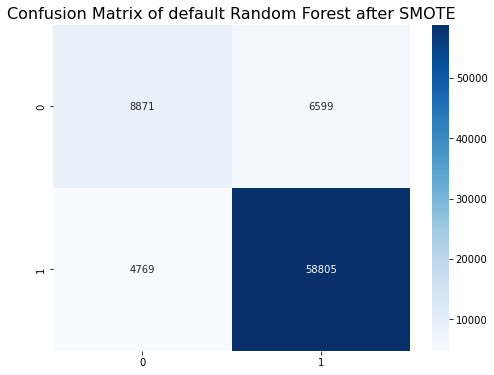

In [215]:
# Evaluate the model
print(f'Accuracy={accuracy_score(y_test, pred_rf_sm):.2f}\nRecall={recall_score(y_test, pred_rf_sm):.2f}\nF1={f1_score(y_test, pred_rf_sm):.2f}\nPrecision={precision_score(y_test, pred_rf_sm):.2f}\nAUC={roc_auc_score(y_test, pred_rf_sm):.2f}')

# Plot the Confusion matrix
cm_rf_smote = confusion_matrix(y_test, pred_rf_sm)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of default Random Forest after SMOTE', size=16)
sns.heatmap(cm_rf_smote, annot=True, cmap='Blues', fmt='g');
plt.savefig('./Materials/cm_rf_smote.png')
plt.show()

In [263]:
result_after_smote = result_after_smote.append({'Classifiers': 'Random Forest after SMOTE-NC',
                                        'Accuracy': accuracy_score(y_test, pred_rf_sm), 
                                        'Recall': recall_score(y_test, pred_rf_sm), 
                                        'F1': f1_score(y_test, pred_rf_sm),
                                        'Precision': precision_score(y_test, pred_rf_sm),
                                        'Specificity': specificity_score(y_test, pred_rf_sm, average='weighted'),
                                        'AUC': roc_auc_score(y_test, pred_rf_sm)}, ignore_index=True)
result_after_smote

C:\Users\AMSE\AppData\Local\Temp\ipykernel_7324\1271024786.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_after_smote = result_after_smote.append({'Classifiers': 'Random Forest after SMOTE-NC with polynomial features',


,Classifiers,Accuracy,Recall,F1,Precision,Specificity,AUC
0,Default ElasticNet Classification after SMOTE-NC,0.783171,0.808428,0.85709,0.911987,0.704636,0.743904
1,Tuned ElasticNet Classification after SMOTE-NC,0.783133,0.808381,0.857062,0.911982,0.704627,0.74388
2,Logistic Classification after SMOTE-NC,0.782918,0.807988,0.856881,0.912072,0.704966,0.743942
3,Tuned Logistic Classification after SMOTE-NC,0.782982,0.808035,0.856924,0.912109,0.705079,0.74403
4,Logistic Classification after SMOTE-NC with po...,0.785309,0.812675,0.858936,0.910782,0.700216,0.742763
5,Random Forest after SMOTE-NC with polynomial f...,0.856181,0.924985,0.911861,0.899104,0.642236,0.749209


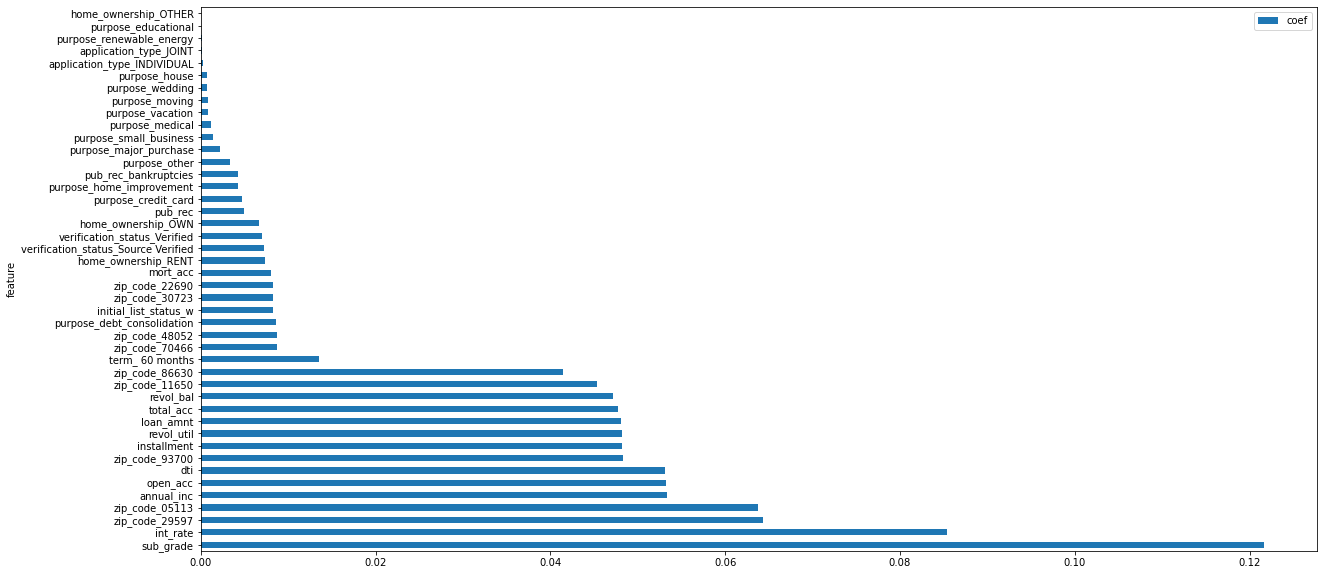

In [220]:
feature_importance = rf_smote.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]
plt.rcParams["figure.figsize"] = (20,10)
 
feature_importance_rf_smote = pd.DataFrame(X_training.columns, columns = ['feature'])
feature_importance_rf_smote['coef'] = feature_importance
feature_importance_rf_smote = feature_importance_rf_smote.sort_values(by = ['coef'], ascending=False)
 
feature_importance_rf_smote_plot = feature_importance_rf_smote.plot.barh(x='feature', y='coef')
plt.savefig('./Materials/FeatureImportance_rf_sm.jpeg')
plt.show()

### Before SMOTE

In [26]:
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [28]:
# build a model
model = Sequential()
model.add(Dense(80, input_shape=(X_sm.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(80, input_shape=(X_sm.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_loss', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)


# fit model
weights = {0:0.045, 1:0.955}
# now we just update our model fit call
history = model.fit(X_training,
                    y_training,
                    callbacks=[es],
                    epochs=10, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    class_weight=weights,
                    shuffle=True,
                    verbose=1)
# 8 mins 11 s to run

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 80)                3840      
                                                                 
 dense_6 (Dense)             (None, 80)                6480      
                                                                 
 dense_7 (Dense)             (None, 50)                4050      
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 16,971
Trainable params: 16,971
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16695/16695 [==========================

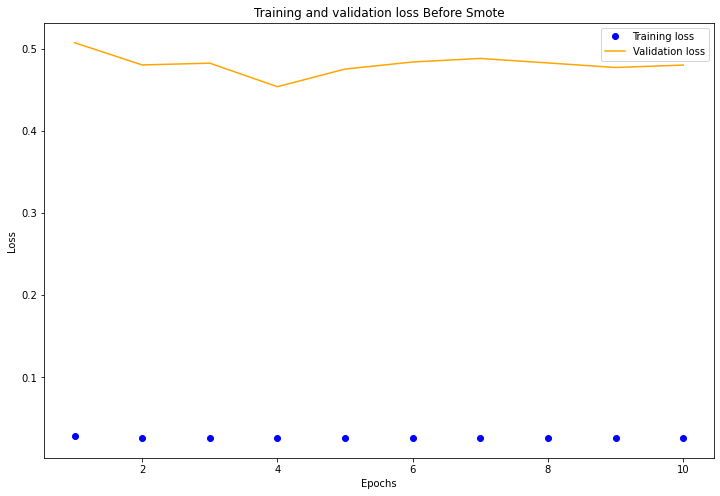

In [29]:
# Model Evaluation
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.figure(figsize=(12,8))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss Before Smote')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('trainvallossbeforsm.jpeg')
plt.legend()
plt.show()

In [30]:
# see how these are numbers between 0 and 1? 
model.predict(X_test) # prob of successes (survival)
np.round(model.predict(X_test),0) # 1 and 0 (survival or not)

preds_NN_before_sm = np.round(model.predict(X_test),0)

2471/2471 [==============================] - 3s 1ms/step


Accuracy = 0.89
Recall =  1.00
F1  = 0.93
Precision = 0.88
AUC = 0.71


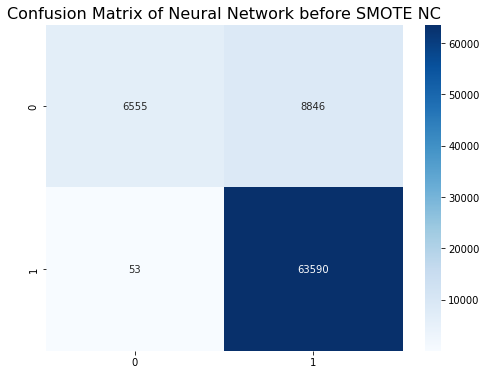

In [32]:
# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds_NN_before_sm):.2f}\nRecall =  {recall_score(y_test,preds_NN_before_sm):.2f}\nF1  = {f1_score(y_test,preds_NN_before_sm):.2f}\nPrecision = {precision_score(y_test,preds_NN_before_sm):.2f}\nAUC = {roc_auc_score(y_test,preds_NN_before_sm):.2f}')
cm = confusion_matrix(y_test,preds_NN_before_sm)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix of Neural Network before SMOTE NC', size=16)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');
plt.savefig('cm_logistic_nosmote')
plt.show()